# Imports and Database Parsing

In [1]:
import pandas as pd
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from google.colab import drive
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler   
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
#uploaded = files.upload() 
import io
drive.mount('/content/gdrive')
df2 = pd.read_csv('/content/gdrive/MyDrive/miRNA/IMTdatabase.csv',sep=';' , encoding='latin-1')

Mounted at /content/gdrive


# Set of mirRNA and variables definition

In [14]:
mirRNA = ['mirlet7','mir145',['mirlet7','mir145'],'logmirlet7','logmir145',['logmirlet7','logmir145']]
v_set = [['obesidade','Idade','Sexo','CT','TG','LDL'], ['PAS','Idade','obesidade'], ['PAS','Idade','IMC'] ,['Diuretico','IECA','BRA','IEBRA','betabloq','BCC','Antaaldost','agoalfacentral','agoalfaper','vasodilat','statinas','AAS'],['Diuretico'],['IECA'],['BRA'],['IEBRA'],['betabloq'],['BCC'],['Antaaldost'],['agoalfacentral'],['agoalfaper'],['vasodilat'],['statinas'],['AAS']]

In [15]:
EPOCHS = 100
BATCH_SIZE = 8
LEARNING_RATE = 0.001

In [16]:
class BinaryClassification(nn.Module):
    def __init__(self,ind):
        super(BinaryClassification, self).__init__()
        self.layer_1 = nn.Linear(ind, 64) 
        self.layer_2 = nn.Linear(64, 32)
        self.layer_out = nn.Linear(32, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(32)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data.to_numpy()
        self.y_data = self.y_data.astype(np.float)
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
        
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)       

In [19]:
def mlp(X_train, X_test, y_train, y_test, features):
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  train_data = TrainData(torch.FloatTensor(X_train), 
                       (y_train))
  test_data = TestData(torch.FloatTensor(X_test))
  train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True )
  test_loader = DataLoader(dataset=test_data, batch_size=1, drop_last=True )
  model = BinaryClassification(len(features))
  model.to(device)
  #print(model)
  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
  model.train()
  for e in range(1, EPOCHS+1):
      epoch_loss = 0
      epoch_acc = 0
      for X_batch, y_batch in train_loader:
          X_batch, y_batch = X_batch.to(device), y_batch.to(device)
          optimizer.zero_grad()
          
          y_pred = model(X_batch)
          
          loss = criterion(y_pred, y_batch.unsqueeze(1))
          acc = binary_acc(y_pred, y_batch.unsqueeze(1))
          
          loss.backward()
          optimizer.step()
          
          epoch_loss += loss.item()
          epoch_acc += acc.item()
          

      #print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
  y_pred_list = []
  model.eval()
  with torch.no_grad():
      for X_batch in test_loader:
          X_batch = X_batch.to(device)
          y_test_pred = model(X_batch)
          y_test_pred = torch.sigmoid(y_test_pred)
          y_pred_tag = torch.round(y_test_pred)
          y_pred_list.append(y_pred_tag.cpu().numpy())

  y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
  return y_pred_list

In [20]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [21]:
def print_roc(y_test,logpred,svmpred,mlppred):
  plt.figure(0).clf()
  plt.figure(figsize=(6, 6), dpi=100)
  fpr, tpr, thresh =  metrics.roc_curve(y_test,  logpred)
  auc = metrics.roc_auc_score(y_test, logpred)
  plt.plot(fpr,tpr,label="Logistic Regression, auc="+str(round(auc,4)))

  fpr, tpr, thresh = metrics.roc_curve(y_test, svmpred)
  auc = metrics.roc_auc_score(y_test, svmpred)
  plt.plot(fpr,tpr,label="SVM Gaussian Kernel, auc="+str(round(auc,4)))

  fpr, tpr, thresh = metrics.roc_curve(y_test, mlppred)
  auc = metrics.roc_auc_score(y_test, mlppred)
  plt.plot(fpr,tpr,label="MultiLayer Perception, auc="+str(round(auc,4)))


  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc=0)
  plt.show()

# Main Execution

mirlet7
['obesidade', 'Idade', 'Sexo', 'CT', 'TG', 'LDL']

Training on:  131
Testing on:  24
Logistic Regression
--------------------
[[ 2  7]
 [ 2 13]]
Accuracy:  62.5 %
              precision    recall  f1-score   support

           0       0.50      0.22      0.31         9
           1       0.65      0.87      0.74        15

    accuracy                           0.62        24
   macro avg       0.57      0.54      0.53        24
weighted avg       0.59      0.62      0.58        24

--------------------
SVM
--------------------
[[ 0  9]
 [ 0 15]]
Accuracy:  62.5 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.62      1.00      0.77        15

    accuracy                           0.62        24
   macro avg       0.31      0.50      0.38        24
weighted avg       0.39      0.62      0.48        24

--------------------
MultiLayer Percepton
--------------------
[[ 3  6]
 [ 4 11]]
Accuracy: 

<Figure size 432x288 with 0 Axes>

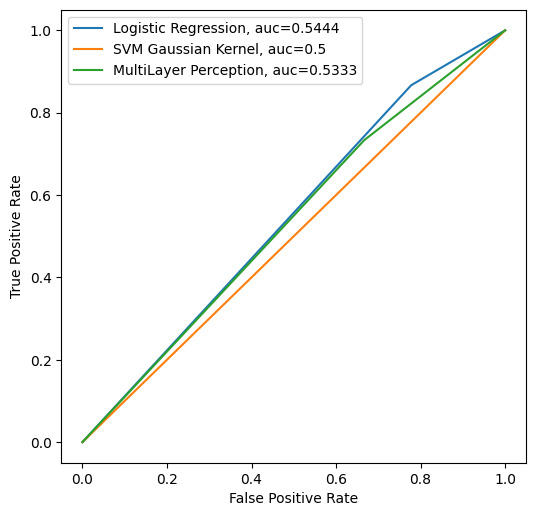

mirlet7
['PAS', 'Idade', 'obesidade']

Training on:  134
Testing on:  24
Logistic Regression
--------------------
[[ 1  8]
 [ 0 15]]
Accuracy:  66.66666666666666 %
              precision    recall  f1-score   support

           0       1.00      0.11      0.20         9
           1       0.65      1.00      0.79        15

    accuracy                           0.67        24
   macro avg       0.83      0.56      0.49        24
weighted avg       0.78      0.67      0.57        24

--------------------
SVM
--------------------
[[ 0  9]
 [ 0 15]]
Accuracy:  62.5 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.62      1.00      0.77        15

    accuracy                           0.62        24
   macro avg       0.31      0.50      0.38        24
weighted avg       0.39      0.62      0.48        24

--------------------
MultiLayer Percepton
--------------------
[[ 2  7]
 [ 1 14]]
Accuracy:  66.666

<Figure size 432x288 with 0 Axes>

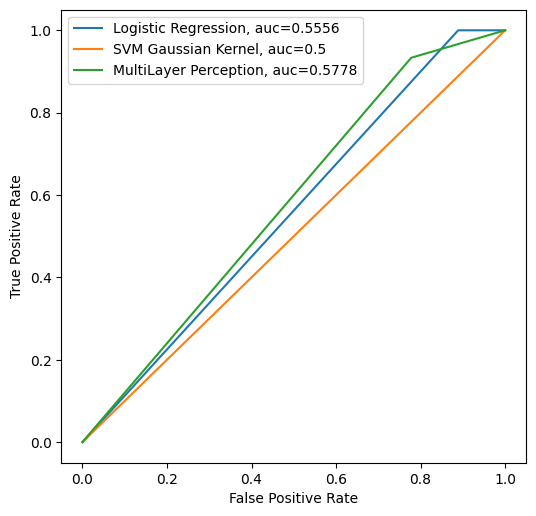

mirlet7
['PAS', 'Idade', 'IMC']

Training on:  133
Testing on:  24
Logistic Regression
--------------------
[[ 1  5]
 [ 1 17]]
Accuracy:  75.0 %
              precision    recall  f1-score   support

           0       0.50      0.17      0.25         6
           1       0.77      0.94      0.85        18

    accuracy                           0.75        24
   macro avg       0.64      0.56      0.55        24
weighted avg       0.70      0.75      0.70        24

--------------------
SVM
--------------------
[[ 0  6]
 [ 0 18]]
Accuracy:  75.0 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.75      1.00      0.86        18

    accuracy                           0.75        24
   macro avg       0.38      0.50      0.43        24
weighted avg       0.56      0.75      0.64        24

--------------------
MultiLayer Percepton
--------------------
[[ 1  5]
 [ 6 12]]
Accuracy:  54.166666666666664 %
    

<Figure size 432x288 with 0 Axes>

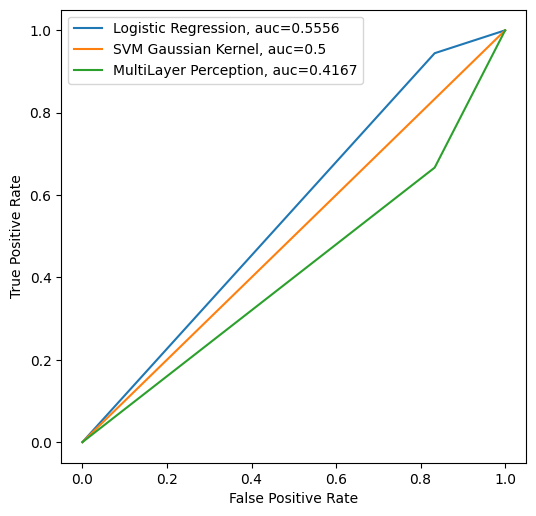

mirlet7
['Diuretico', 'IECA', 'BRA', 'IEBRA', 'betabloq', 'BCC', 'Antaaldost', 'agoalfacentral', 'agoalfaper', 'vasodilat', 'statinas', 'AAS']

Training on:  132
Testing on:  24
Logistic Regression
--------------------
[[ 0 10]
 [ 0 14]]
Accuracy:  58.333333333333336 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.58      1.00      0.74        14

    accuracy                           0.58        24
   macro avg       0.29      0.50      0.37        24
weighted avg       0.34      0.58      0.43        24

--------------------
SVM
--------------------
[[ 0 10]
 [ 1 13]]
Accuracy:  54.166666666666664 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.57      0.93      0.70        14

    accuracy                           0.54        24
   macro avg       0.28      0.46      0.35        24
weighted avg       0.33      0.54 

<Figure size 432x288 with 0 Axes>

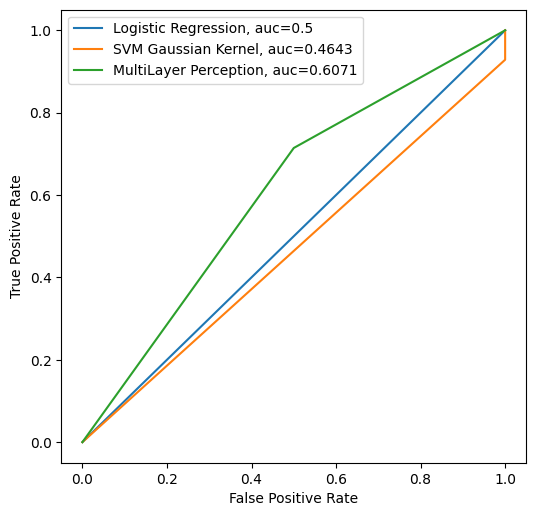

mirlet7
['Diuretico']

Training on:  134
Testing on:  24
Logistic Regression
--------------------
[[ 0 10]
 [ 0 14]]
Accuracy:  58.333333333333336 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.58      1.00      0.74        14

    accuracy                           0.58        24
   macro avg       0.29      0.50      0.37        24
weighted avg       0.34      0.58      0.43        24

--------------------
SVM
--------------------
[[ 0 10]
 [ 0 14]]
Accuracy:  58.333333333333336 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.58      1.00      0.74        14

    accuracy                           0.58        24
   macro avg       0.29      0.50      0.37        24
weighted avg       0.34      0.58      0.43        24

--------------------
MultiLayer Percepton
--------------------
[[ 0 10]
 [ 0 14]]
Accuracy:  58.3333

<Figure size 432x288 with 0 Axes>

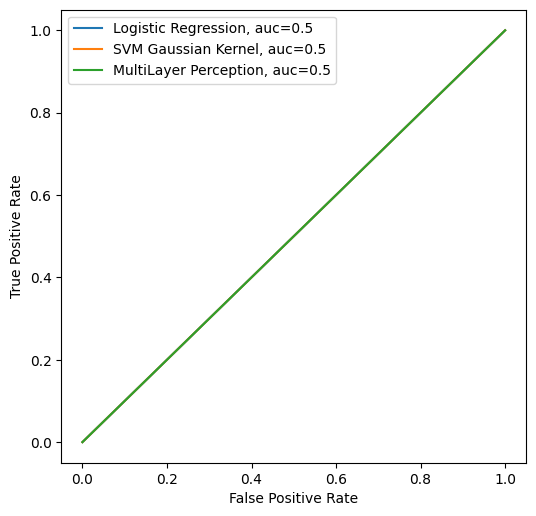

mirlet7
['IECA']

Training on:  134
Testing on:  24
Logistic Regression
--------------------
[[ 0  7]
 [ 0 17]]
Accuracy:  70.83333333333334 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.71      1.00      0.83        17

    accuracy                           0.71        24
   macro avg       0.35      0.50      0.41        24
weighted avg       0.50      0.71      0.59        24

--------------------
SVM
--------------------
[[ 0  7]
 [ 0 17]]
Accuracy:  70.83333333333334 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.71      1.00      0.83        17

    accuracy                           0.71        24
   macro avg       0.35      0.50      0.41        24
weighted avg       0.50      0.71      0.59        24

--------------------
MultiLayer Percepton
--------------------
[[ 0  7]
 [ 0 17]]
Accuracy:  70.83333333333

<Figure size 432x288 with 0 Axes>

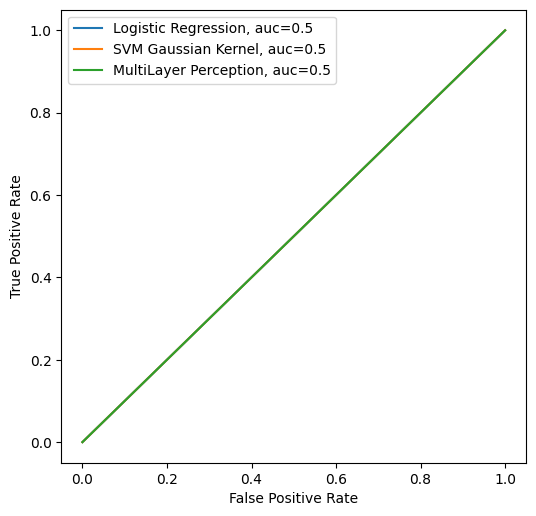

mirlet7
['BRA']

Training on:  134
Testing on:  24
Logistic Regression
--------------------
[[ 0  8]
 [ 0 16]]
Accuracy:  66.66666666666666 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.67      1.00      0.80        16

    accuracy                           0.67        24
   macro avg       0.33      0.50      0.40        24
weighted avg       0.44      0.67      0.53        24

--------------------
SVM
--------------------
[[ 0  8]
 [ 0 16]]
Accuracy:  66.66666666666666 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.67      1.00      0.80        16

    accuracy                           0.67        24
   macro avg       0.33      0.50      0.40        24
weighted avg       0.44      0.67      0.53        24

--------------------
MultiLayer Percepton
--------------------
[[ 0  8]
 [ 0 16]]
Accuracy:  66.666666666666

<Figure size 432x288 with 0 Axes>

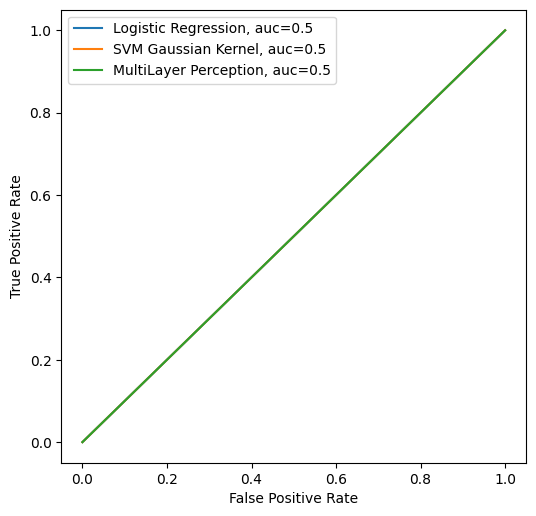

mirlet7
['IEBRA']

Training on:  134
Testing on:  24
Logistic Regression
--------------------
[[ 0 11]
 [ 0 13]]
Accuracy:  54.166666666666664 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.54      1.00      0.70        13

    accuracy                           0.54        24
   macro avg       0.27      0.50      0.35        24
weighted avg       0.29      0.54      0.38        24

--------------------
SVM
--------------------
[[ 0 11]
 [ 0 13]]
Accuracy:  54.166666666666664 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.54      1.00      0.70        13

    accuracy                           0.54        24
   macro avg       0.27      0.50      0.35        24
weighted avg       0.29      0.54      0.38        24

--------------------
MultiLayer Percepton
--------------------
[[ 1 10]
 [ 1 12]]
Accuracy:  54.16666666

<Figure size 432x288 with 0 Axes>

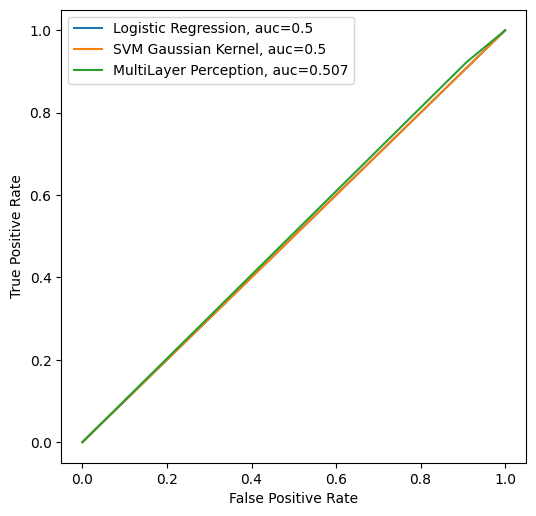

mirlet7
['betabloq']

Training on:  134
Testing on:  24
Logistic Regression
--------------------
[[ 0  7]
 [ 0 17]]
Accuracy:  70.83333333333334 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.71      1.00      0.83        17

    accuracy                           0.71        24
   macro avg       0.35      0.50      0.41        24
weighted avg       0.50      0.71      0.59        24

--------------------
SVM
--------------------
[[ 0  7]
 [ 0 17]]
Accuracy:  70.83333333333334 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.71      1.00      0.83        17

    accuracy                           0.71        24
   macro avg       0.35      0.50      0.41        24
weighted avg       0.50      0.71      0.59        24

--------------------
MultiLayer Percepton
--------------------
[[ 0  7]
 [ 0 17]]
Accuracy:  70.8333333

<Figure size 432x288 with 0 Axes>

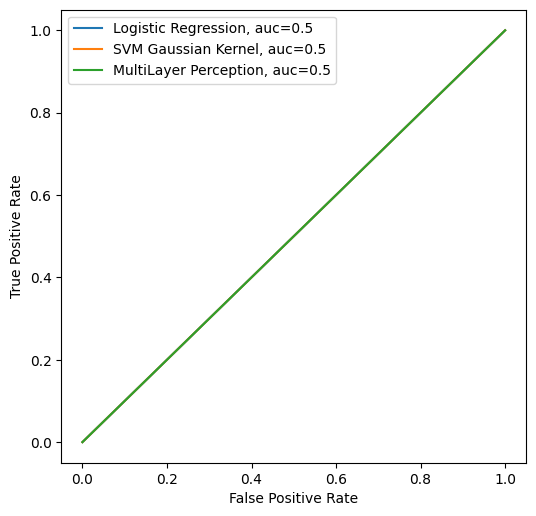

mirlet7
['BCC']

Training on:  134
Testing on:  24
Logistic Regression
--------------------
[[ 0  9]
 [ 0 15]]
Accuracy:  62.5 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.62      1.00      0.77        15

    accuracy                           0.62        24
   macro avg       0.31      0.50      0.38        24
weighted avg       0.39      0.62      0.48        24

--------------------
SVM
--------------------
[[ 0  9]
 [ 0 15]]
Accuracy:  62.5 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.62      1.00      0.77        15

    accuracy                           0.62        24
   macro avg       0.31      0.50      0.38        24
weighted avg       0.39      0.62      0.48        24

--------------------
MultiLayer Percepton
--------------------
[[ 0  9]
 [ 0 15]]
Accuracy:  62.5 %
              precision    recall 

<Figure size 432x288 with 0 Axes>

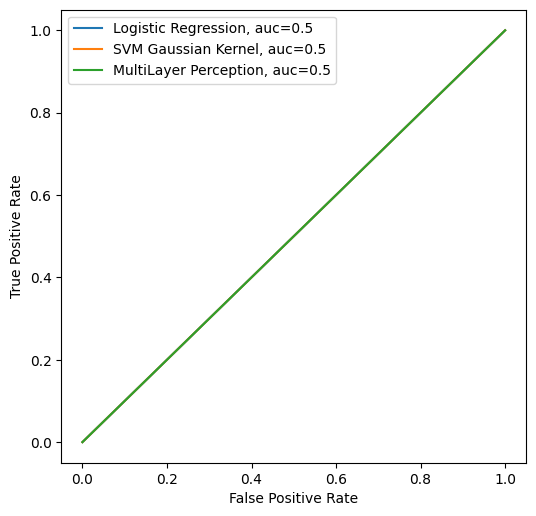

mirlet7
['Antaaldost']

Training on:  134
Testing on:  24
Logistic Regression
--------------------
[[ 0 10]
 [ 0 14]]
Accuracy:  58.333333333333336 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.58      1.00      0.74        14

    accuracy                           0.58        24
   macro avg       0.29      0.50      0.37        24
weighted avg       0.34      0.58      0.43        24

--------------------
SVM
--------------------
[[ 0 10]
 [ 0 14]]
Accuracy:  58.333333333333336 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.58      1.00      0.74        14

    accuracy                           0.58        24
   macro avg       0.29      0.50      0.37        24
weighted avg       0.34      0.58      0.43        24

--------------------
MultiLayer Percepton
--------------------
[[ 0 10]
 [ 0 14]]
Accuracy:  58.333

<Figure size 432x288 with 0 Axes>

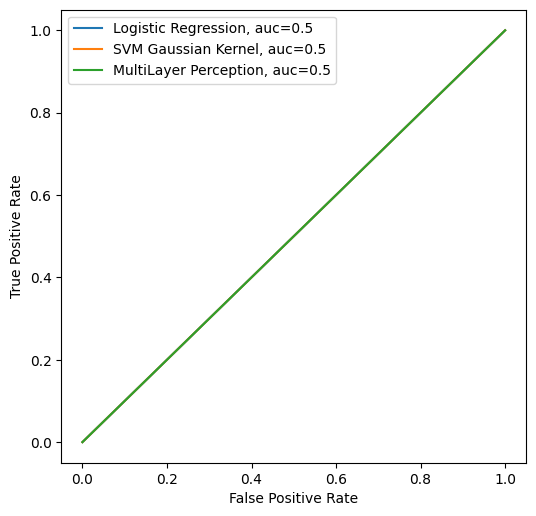

mirlet7
['agoalfacentral']

Training on:  133
Testing on:  24
Logistic Regression
--------------------
[[ 0 11]
 [ 0 13]]
Accuracy:  54.166666666666664 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.54      1.00      0.70        13

    accuracy                           0.54        24
   macro avg       0.27      0.50      0.35        24
weighted avg       0.29      0.54      0.38        24

--------------------
SVM
--------------------
[[ 0 11]
 [ 0 13]]
Accuracy:  54.166666666666664 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.54      1.00      0.70        13

    accuracy                           0.54        24
   macro avg       0.27      0.50      0.35        24
weighted avg       0.29      0.54      0.38        24

--------------------
MultiLayer Percepton
--------------------
[[ 0 11]
 [ 1 12]]
Accuracy:  50

<Figure size 432x288 with 0 Axes>

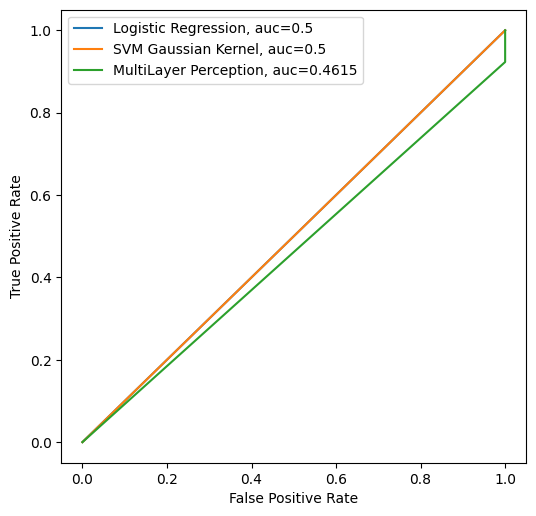

mirlet7
['agoalfaper']

Training on:  134
Testing on:  24
Logistic Regression
--------------------
[[ 0  6]
 [ 0 18]]
Accuracy:  75.0 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.75      1.00      0.86        18

    accuracy                           0.75        24
   macro avg       0.38      0.50      0.43        24
weighted avg       0.56      0.75      0.64        24

--------------------
SVM
--------------------
[[ 0  6]
 [ 0 18]]
Accuracy:  75.0 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.75      1.00      0.86        18

    accuracy                           0.75        24
   macro avg       0.38      0.50      0.43        24
weighted avg       0.56      0.75      0.64        24

--------------------
MultiLayer Percepton
--------------------
[[ 0  6]
 [ 0 18]]
Accuracy:  75.0 %
              precision    

<Figure size 432x288 with 0 Axes>

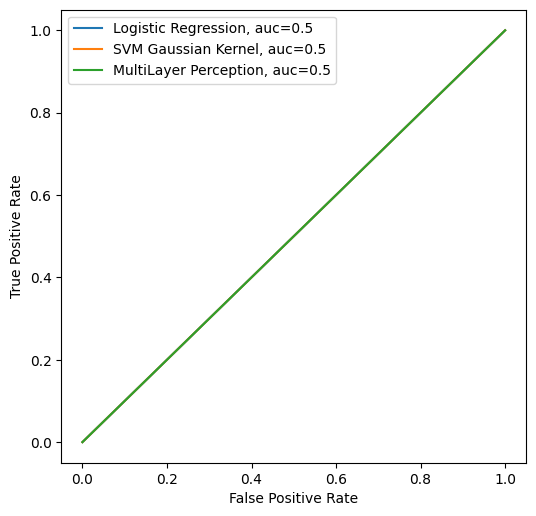

mirlet7
['vasodilat']

Training on:  133
Testing on:  24
Logistic Regression
--------------------
[[ 0 10]
 [ 0 14]]
Accuracy:  58.333333333333336 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.58      1.00      0.74        14

    accuracy                           0.58        24
   macro avg       0.29      0.50      0.37        24
weighted avg       0.34      0.58      0.43        24

--------------------
SVM
--------------------
[[ 0 10]
 [ 0 14]]
Accuracy:  58.333333333333336 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.58      1.00      0.74        14

    accuracy                           0.58        24
   macro avg       0.29      0.50      0.37        24
weighted avg       0.34      0.58      0.43        24

--------------------
MultiLayer Percepton
--------------------
[[ 0 10]
 [ 1 13]]
Accuracy:  54.1666

<Figure size 432x288 with 0 Axes>

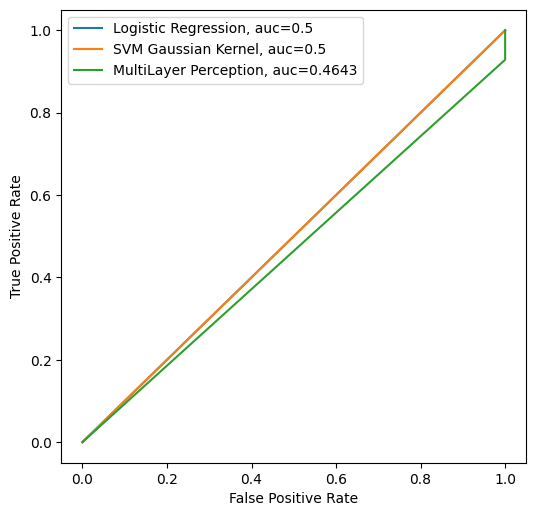

mirlet7
['statinas']

Training on:  134
Testing on:  24
Logistic Regression
--------------------
[[ 0  7]
 [ 0 17]]
Accuracy:  70.83333333333334 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.71      1.00      0.83        17

    accuracy                           0.71        24
   macro avg       0.35      0.50      0.41        24
weighted avg       0.50      0.71      0.59        24

--------------------
SVM
--------------------
[[ 0  7]
 [ 0 17]]
Accuracy:  70.83333333333334 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.71      1.00      0.83        17

    accuracy                           0.71        24
   macro avg       0.35      0.50      0.41        24
weighted avg       0.50      0.71      0.59        24

--------------------
MultiLayer Percepton
--------------------
[[ 0  7]
 [ 0 17]]
Accuracy:  70.8333333

<Figure size 432x288 with 0 Axes>

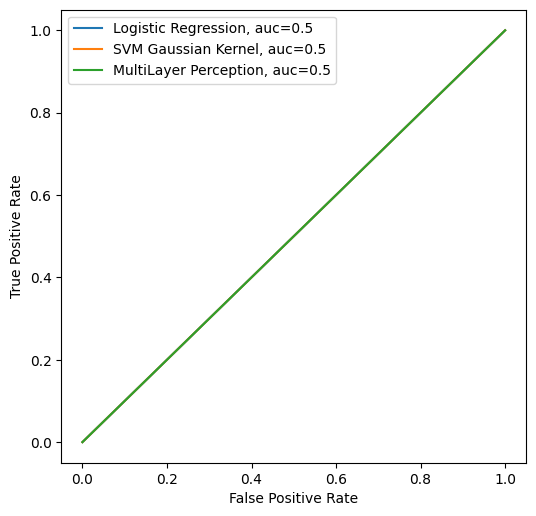

mirlet7
['AAS']

Training on:  134
Testing on:  24
Logistic Regression
--------------------
[[ 0 10]
 [ 0 14]]
Accuracy:  58.333333333333336 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.58      1.00      0.74        14

    accuracy                           0.58        24
   macro avg       0.29      0.50      0.37        24
weighted avg       0.34      0.58      0.43        24

--------------------
SVM
--------------------
[[ 0 10]
 [ 0 14]]
Accuracy:  58.333333333333336 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.58      1.00      0.74        14

    accuracy                           0.58        24
   macro avg       0.29      0.50      0.37        24
weighted avg       0.34      0.58      0.43        24

--------------------
MultiLayer Percepton
--------------------
[[ 0 10]
 [ 0 14]]
Accuracy:  58.3333333333

<Figure size 432x288 with 0 Axes>

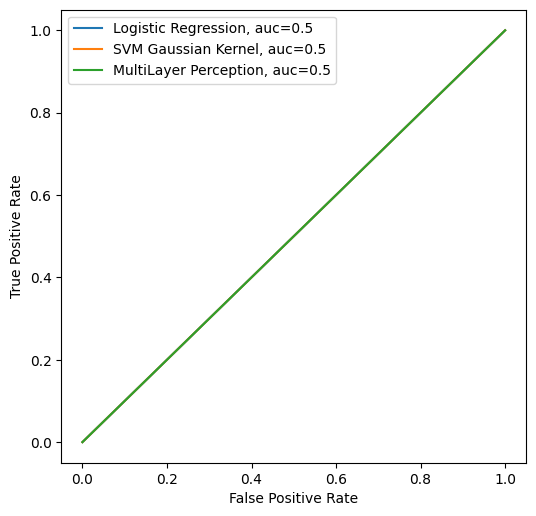

mir145
['obesidade', 'Idade', 'Sexo', 'CT', 'TG', 'LDL']

Training on:  136
Testing on:  25
Logistic Regression
--------------------
[[ 1 10]
 [ 2 12]]
Accuracy:  52.0 %
              precision    recall  f1-score   support

           0       0.33      0.09      0.14        11
           1       0.55      0.86      0.67        14

    accuracy                           0.52        25
   macro avg       0.44      0.47      0.40        25
weighted avg       0.45      0.52      0.44        25

--------------------
SVM
--------------------
[[ 0 11]
 [ 0 14]]
Accuracy:  56.00000000000001 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.56      1.00      0.72        14

    accuracy                           0.56        25
   macro avg       0.28      0.50      0.36        25
weighted avg       0.31      0.56      0.40        25

--------------------
MultiLayer Percepton
--------------------
[[ 3  8]
 [ 2 12]

<Figure size 432x288 with 0 Axes>

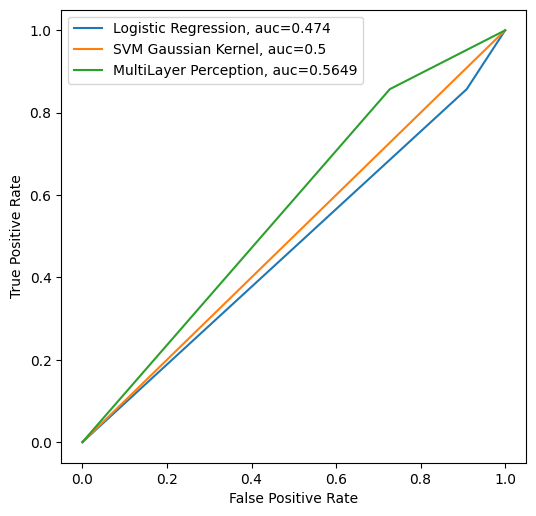

mir145
['PAS', 'Idade', 'obesidade']

Training on:  139
Testing on:  25
Logistic Regression
--------------------
[[ 1  7]
 [ 0 17]]
Accuracy:  72.0 %
              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.71      1.00      0.83        17

    accuracy                           0.72        25
   macro avg       0.85      0.56      0.53        25
weighted avg       0.80      0.72      0.64        25

--------------------
SVM
--------------------
[[ 0  8]
 [ 0 17]]
Accuracy:  68.0 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.68      1.00      0.81        17

    accuracy                           0.68        25
   macro avg       0.34      0.50      0.40        25
weighted avg       0.46      0.68      0.55        25

--------------------
MultiLayer Percepton
--------------------
[[ 2  6]
 [ 1 16]]
Accuracy:  72.0 %
             

<Figure size 432x288 with 0 Axes>

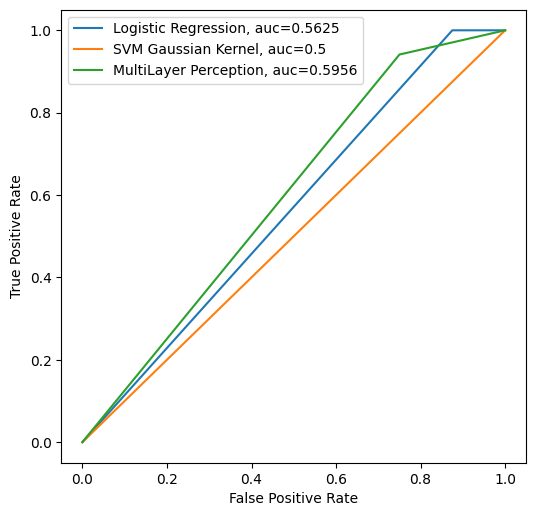

mir145
['PAS', 'Idade', 'IMC']

Training on:  138
Testing on:  25
Logistic Regression
--------------------
[[ 2  5]
 [ 6 12]]
Accuracy:  56.00000000000001 %
              precision    recall  f1-score   support

           0       0.25      0.29      0.27         7
           1       0.71      0.67      0.69        18

    accuracy                           0.56        25
   macro avg       0.48      0.48      0.48        25
weighted avg       0.58      0.56      0.57        25

--------------------
SVM
--------------------
[[ 0  7]
 [ 0 18]]
Accuracy:  72.0 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.72      1.00      0.84        18

    accuracy                           0.72        25
   macro avg       0.36      0.50      0.42        25
weighted avg       0.52      0.72      0.60        25

--------------------
MultiLayer Percepton
--------------------
[[ 3  4]
 [ 8 10]]
Accuracy:  52.0 %
      

<Figure size 432x288 with 0 Axes>

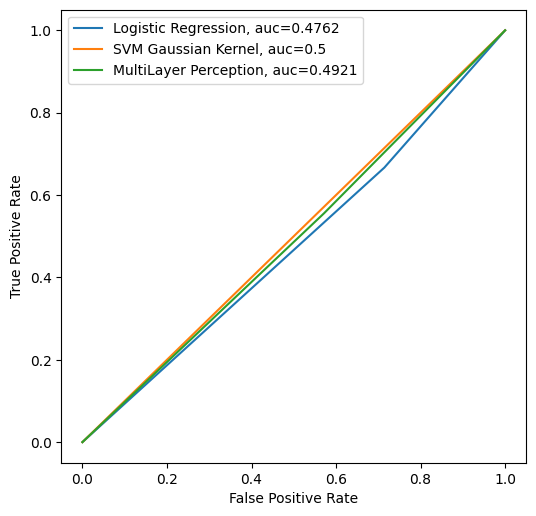

mir145
['Diuretico', 'IECA', 'BRA', 'IEBRA', 'betabloq', 'BCC', 'Antaaldost', 'agoalfacentral', 'agoalfaper', 'vasodilat', 'statinas', 'AAS']

Training on:  137
Testing on:  25
Logistic Regression
--------------------
[[ 1  9]
 [ 0 15]]
Accuracy:  64.0 %
              precision    recall  f1-score   support

           0       1.00      0.10      0.18        10
           1       0.62      1.00      0.77        15

    accuracy                           0.64        25
   macro avg       0.81      0.55      0.48        25
weighted avg       0.78      0.64      0.53        25

--------------------
SVM
--------------------
[[ 2  8]
 [ 0 15]]
Accuracy:  68.0 %
              precision    recall  f1-score   support

           0       1.00      0.20      0.33        10
           1       0.65      1.00      0.79        15

    accuracy                           0.68        25
   macro avg       0.83      0.60      0.56        25
weighted avg       0.79      0.68      0.61        25

--------

<Figure size 432x288 with 0 Axes>

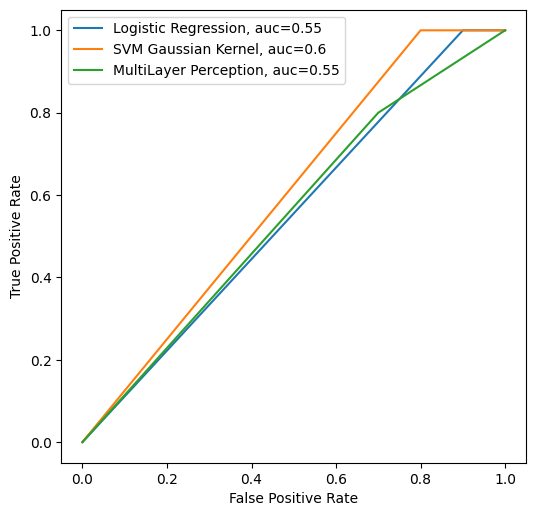

mir145
['Diuretico']

Training on:  139
Testing on:  25
Logistic Regression
--------------------
[[ 0  6]
 [ 1 18]]
Accuracy:  72.0 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.75      0.95      0.84        19

    accuracy                           0.72        25
   macro avg       0.38      0.47      0.42        25
weighted avg       0.57      0.72      0.64        25

--------------------
SVM
--------------------
[[ 0  6]
 [ 1 18]]
Accuracy:  72.0 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.75      0.95      0.84        19

    accuracy                           0.72        25
   macro avg       0.38      0.47      0.42        25
weighted avg       0.57      0.72      0.64        25

--------------------
MultiLayer Percepton
--------------------
[[ 0  6]
 [ 1 18]]
Accuracy:  72.0 %
              precision    re

<Figure size 432x288 with 0 Axes>

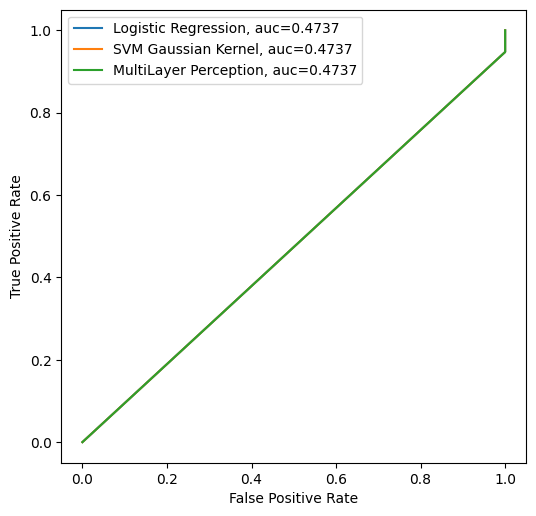

mir145
['IECA']

Training on:  139
Testing on:  25
Logistic Regression
--------------------
[[ 1  8]
 [ 0 16]]
Accuracy:  68.0 %
              precision    recall  f1-score   support

           0       1.00      0.11      0.20         9
           1       0.67      1.00      0.80        16

    accuracy                           0.68        25
   macro avg       0.83      0.56      0.50        25
weighted avg       0.79      0.68      0.58        25

--------------------
SVM
--------------------
[[ 1  8]
 [ 0 16]]
Accuracy:  68.0 %
              precision    recall  f1-score   support

           0       1.00      0.11      0.20         9
           1       0.67      1.00      0.80        16

    accuracy                           0.68        25
   macro avg       0.83      0.56      0.50        25
weighted avg       0.79      0.68      0.58        25

--------------------
MultiLayer Percepton
--------------------
[[ 2  7]
 [ 0 16]]
Accuracy:  72.0 %
              precision    recall 

<Figure size 432x288 with 0 Axes>

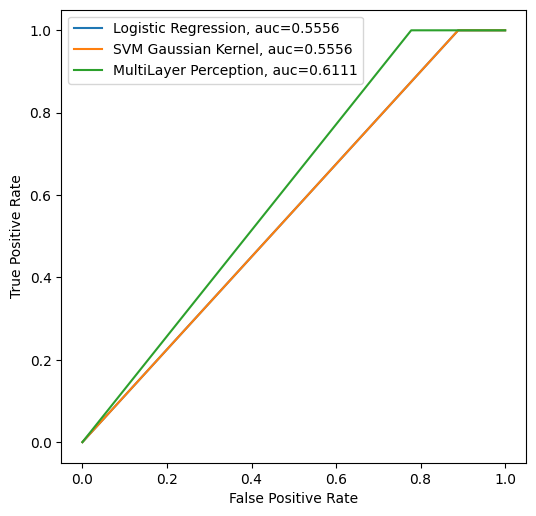

mir145
['BRA']

Training on:  139
Testing on:  25
Logistic Regression
--------------------
[[ 2  6]
 [ 3 14]]
Accuracy:  64.0 %
              precision    recall  f1-score   support

           0       0.40      0.25      0.31         8
           1       0.70      0.82      0.76        17

    accuracy                           0.64        25
   macro avg       0.55      0.54      0.53        25
weighted avg       0.60      0.64      0.61        25

--------------------
SVM
--------------------
[[ 2  6]
 [ 3 14]]
Accuracy:  64.0 %
              precision    recall  f1-score   support

           0       0.40      0.25      0.31         8
           1       0.70      0.82      0.76        17

    accuracy                           0.64        25
   macro avg       0.55      0.54      0.53        25
weighted avg       0.60      0.64      0.61        25

--------------------
MultiLayer Percepton
--------------------
[[ 2  6]
 [ 3 14]]
Accuracy:  64.0 %
              precision    recall  

<Figure size 432x288 with 0 Axes>

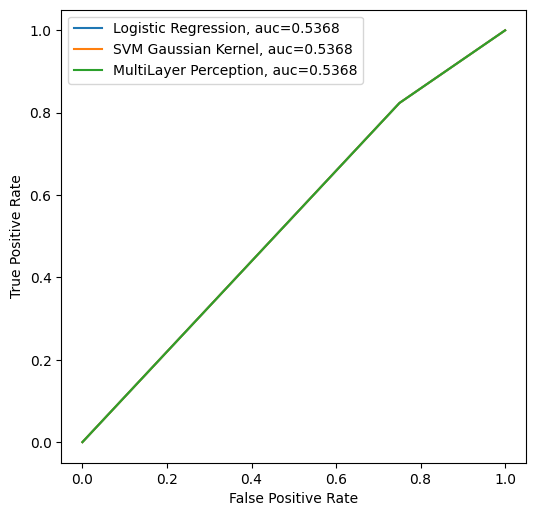

mir145
['IEBRA']

Training on:  139
Testing on:  25
Logistic Regression
--------------------
[[ 1  9]
 [ 0 15]]
Accuracy:  64.0 %
              precision    recall  f1-score   support

           0       1.00      0.10      0.18        10
           1       0.62      1.00      0.77        15

    accuracy                           0.64        25
   macro avg       0.81      0.55      0.48        25
weighted avg       0.78      0.64      0.53        25

--------------------
SVM
--------------------
[[ 0 10]
 [ 1 14]]
Accuracy:  56.00000000000001 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.58      0.93      0.72        15

    accuracy                           0.56        25
   macro avg       0.29      0.47      0.36        25
weighted avg       0.35      0.56      0.43        25

--------------------
MultiLayer Percepton
--------------------
[[ 1  9]
 [ 0 15]]
Accuracy:  64.0 %
              precis

<Figure size 432x288 with 0 Axes>

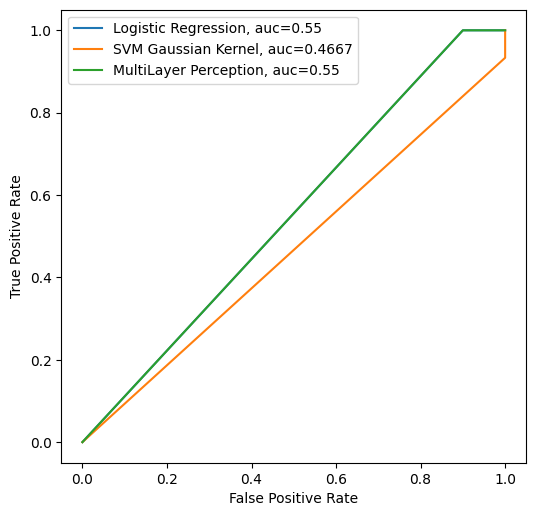

mir145
['betabloq']

Training on:  139
Testing on:  25
Logistic Regression
--------------------
[[ 0  6]
 [ 0 19]]
Accuracy:  76.0 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.76      1.00      0.86        19

    accuracy                           0.76        25
   macro avg       0.38      0.50      0.43        25
weighted avg       0.58      0.76      0.66        25

--------------------
SVM
--------------------
[[ 0  6]
 [ 0 19]]
Accuracy:  76.0 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.76      1.00      0.86        19

    accuracy                           0.76        25
   macro avg       0.38      0.50      0.43        25
weighted avg       0.58      0.76      0.66        25

--------------------
MultiLayer Percepton
--------------------
[[ 0  6]
 [ 0 19]]
Accuracy:  76.0 %
              precision    rec

<Figure size 432x288 with 0 Axes>

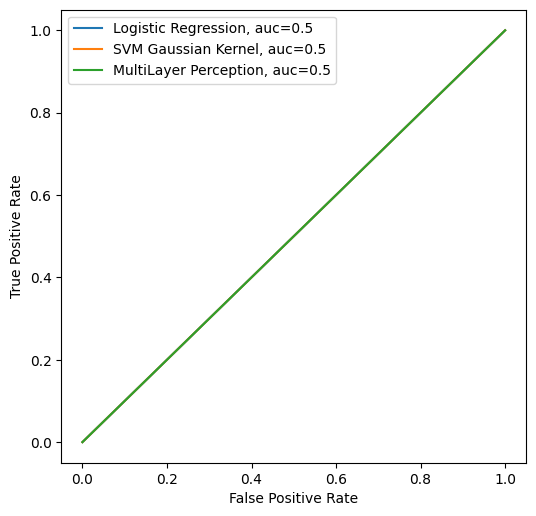

mir145
['BCC']

Training on:  139
Testing on:  25
Logistic Regression
--------------------
[[ 1  8]
 [ 0 16]]
Accuracy:  68.0 %
              precision    recall  f1-score   support

           0       1.00      0.11      0.20         9
           1       0.67      1.00      0.80        16

    accuracy                           0.68        25
   macro avg       0.83      0.56      0.50        25
weighted avg       0.79      0.68      0.58        25

--------------------
SVM
--------------------
[[ 2  7]
 [ 0 16]]
Accuracy:  72.0 %
              precision    recall  f1-score   support

           0       1.00      0.22      0.36         9
           1       0.70      1.00      0.82        16

    accuracy                           0.72        25
   macro avg       0.85      0.61      0.59        25
weighted avg       0.81      0.72      0.66        25

--------------------
MultiLayer Percepton
--------------------
[[ 1  8]
 [ 1 15]]
Accuracy:  64.0 %
              precision    recall  

<Figure size 432x288 with 0 Axes>

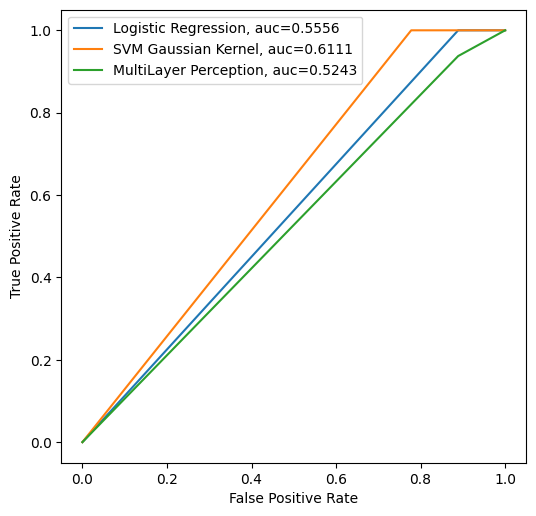

mir145
['Antaaldost']

Training on:  139
Testing on:  25
Logistic Regression
--------------------
[[ 0  6]
 [ 1 18]]
Accuracy:  72.0 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.75      0.95      0.84        19

    accuracy                           0.72        25
   macro avg       0.38      0.47      0.42        25
weighted avg       0.57      0.72      0.64        25

--------------------
SVM
--------------------
[[ 0  6]
 [ 1 18]]
Accuracy:  72.0 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.75      0.95      0.84        19

    accuracy                           0.72        25
   macro avg       0.38      0.47      0.42        25
weighted avg       0.57      0.72      0.64        25

--------------------
MultiLayer Percepton
--------------------
[[ 0  6]
 [ 1 18]]
Accuracy:  72.0 %
              precision    r

<Figure size 432x288 with 0 Axes>

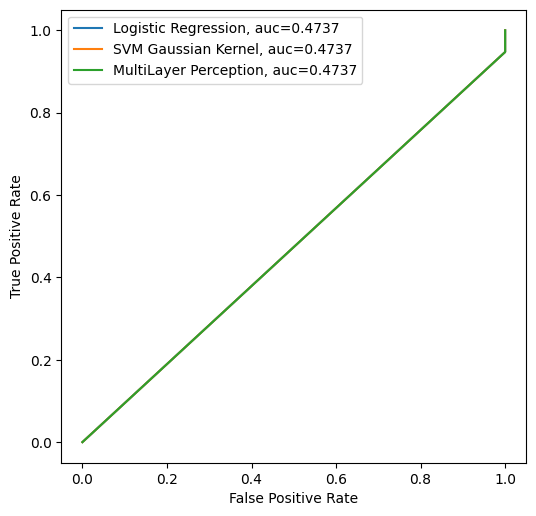

mir145
['agoalfacentral']

Training on:  138
Testing on:  25
Logistic Regression
--------------------
[[ 1  2]
 [ 0 22]]
Accuracy:  92.0 %
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.92      1.00      0.96        22

    accuracy                           0.92        25
   macro avg       0.96      0.67      0.73        25
weighted avg       0.93      0.92      0.90        25

--------------------
SVM
--------------------
[[ 1  2]
 [ 0 22]]
Accuracy:  92.0 %
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.92      1.00      0.96        22

    accuracy                           0.92        25
   macro avg       0.96      0.67      0.73        25
weighted avg       0.93      0.92      0.90        25

--------------------
MultiLayer Percepton
--------------------
[[ 2  1]
 [ 0 22]]
Accuracy:  96.0 %
              precision 

<Figure size 432x288 with 0 Axes>

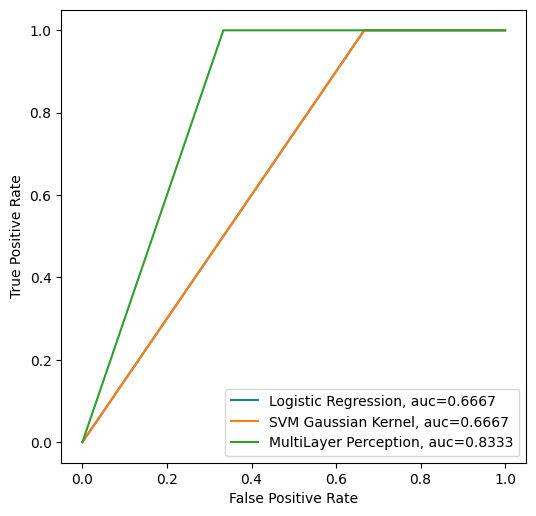

mir145
['agoalfaper']

Training on:  139
Testing on:  25
Logistic Regression
--------------------
[[ 1  7]
 [ 0 17]]
Accuracy:  72.0 %
              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.71      1.00      0.83        17

    accuracy                           0.72        25
   macro avg       0.85      0.56      0.53        25
weighted avg       0.80      0.72      0.64        25

--------------------
SVM
--------------------
[[ 1  7]
 [ 0 17]]
Accuracy:  72.0 %
              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.71      1.00      0.83        17

    accuracy                           0.72        25
   macro avg       0.85      0.56      0.53        25
weighted avg       0.80      0.72      0.64        25

--------------------
MultiLayer Percepton
--------------------
[[ 1  7]
 [ 0 17]]
Accuracy:  72.0 %
              precision    r

<Figure size 432x288 with 0 Axes>

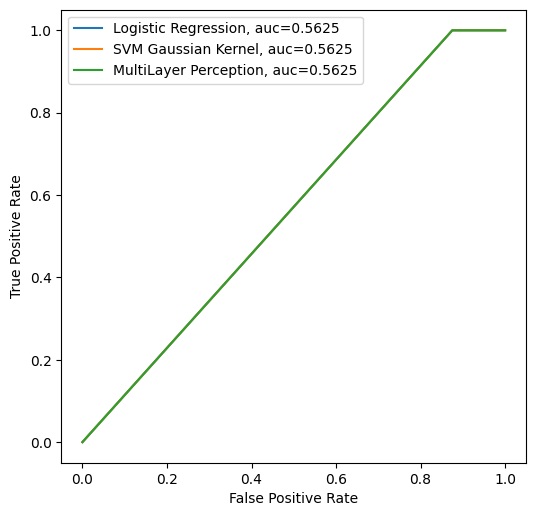

mir145
['vasodilat']

Training on:  138
Testing on:  25
Logistic Regression
--------------------
[[ 0 10]
 [ 0 15]]
Accuracy:  60.0 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.60      1.00      0.75        15

    accuracy                           0.60        25
   macro avg       0.30      0.50      0.37        25
weighted avg       0.36      0.60      0.45        25

--------------------
SVM
--------------------
[[ 2  8]
 [ 0 15]]
Accuracy:  68.0 %
              precision    recall  f1-score   support

           0       1.00      0.20      0.33        10
           1       0.65      1.00      0.79        15

    accuracy                           0.68        25
   macro avg       0.83      0.60      0.56        25
weighted avg       0.79      0.68      0.61        25

--------------------
MultiLayer Percepton
--------------------
[[ 2  8]
 [ 0 15]]
Accuracy:  68.0 %
              precision    re

<Figure size 432x288 with 0 Axes>

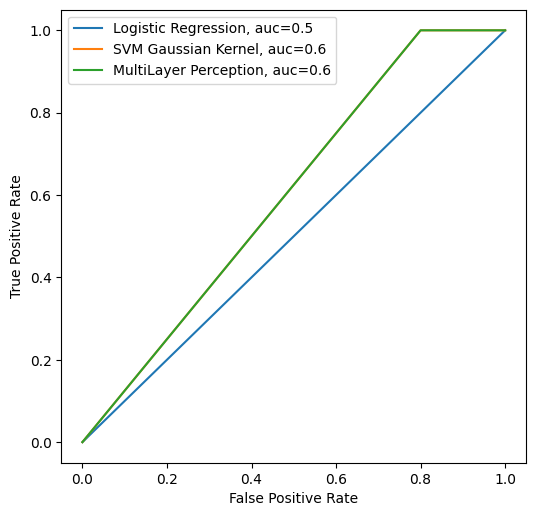

mir145
['statinas']

Training on:  139
Testing on:  25
Logistic Regression
--------------------
[[ 1  6]
 [ 1 17]]
Accuracy:  72.0 %
              precision    recall  f1-score   support

           0       0.50      0.14      0.22         7
           1       0.74      0.94      0.83        18

    accuracy                           0.72        25
   macro avg       0.62      0.54      0.53        25
weighted avg       0.67      0.72      0.66        25

--------------------
SVM
--------------------
[[ 1  6]
 [ 1 17]]
Accuracy:  72.0 %
              precision    recall  f1-score   support

           0       0.50      0.14      0.22         7
           1       0.74      0.94      0.83        18

    accuracy                           0.72        25
   macro avg       0.62      0.54      0.53        25
weighted avg       0.67      0.72      0.66        25

--------------------
MultiLayer Percepton
--------------------
[[ 1  6]
 [ 1 17]]
Accuracy:  72.0 %
              precision    rec

<Figure size 432x288 with 0 Axes>

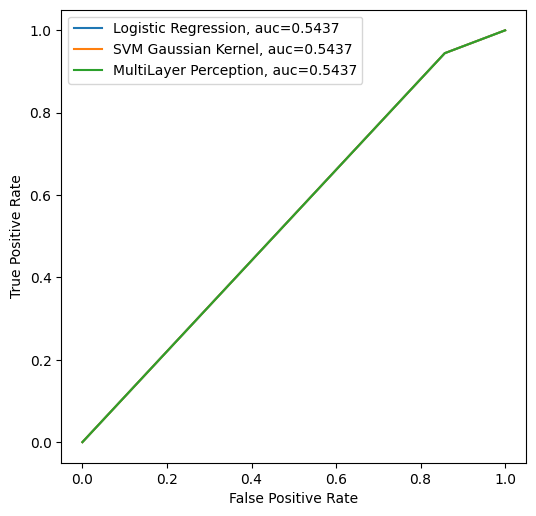

mir145
['AAS']

Training on:  139
Testing on:  25
Logistic Regression
--------------------
[[ 1  8]
 [ 0 16]]
Accuracy:  68.0 %
              precision    recall  f1-score   support

           0       1.00      0.11      0.20         9
           1       0.67      1.00      0.80        16

    accuracy                           0.68        25
   macro avg       0.83      0.56      0.50        25
weighted avg       0.79      0.68      0.58        25

--------------------
SVM
--------------------
[[ 1  8]
 [ 0 16]]
Accuracy:  68.0 %
              precision    recall  f1-score   support

           0       1.00      0.11      0.20         9
           1       0.67      1.00      0.80        16

    accuracy                           0.68        25
   macro avg       0.83      0.56      0.50        25
weighted avg       0.79      0.68      0.58        25

--------------------
MultiLayer Percepton
--------------------
[[ 0  9]
 [ 0 16]]
Accuracy:  64.0 %
              precision    recall  

<Figure size 432x288 with 0 Axes>

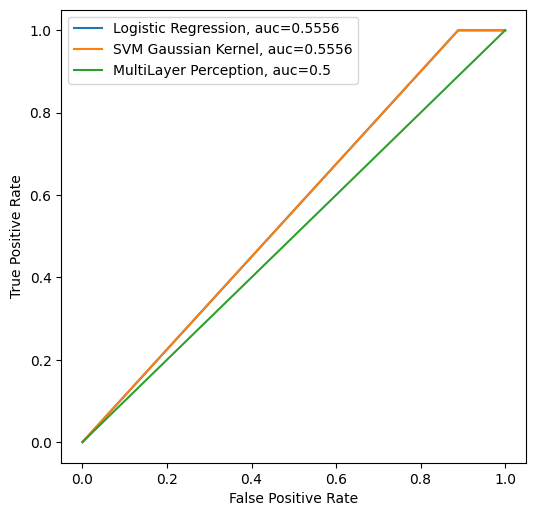

['mirlet7', 'mir145']
['obesidade', 'Idade', 'Sexo', 'CT', 'TG', 'LDL']

Training on:  124
Testing on:  22
Logistic Regression
--------------------
[[ 2  4]
 [ 0 16]]
Accuracy:  81.81818181818183 %
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         6
           1       0.80      1.00      0.89        16

    accuracy                           0.82        22
   macro avg       0.90      0.67      0.69        22
weighted avg       0.85      0.82      0.78        22

--------------------
SVM
--------------------
[[ 0  6]
 [ 0 16]]
Accuracy:  72.72727272727273 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.73      1.00      0.84        16

    accuracy                           0.73        22
   macro avg       0.36      0.50      0.42        22
weighted avg       0.53      0.73      0.61        22

--------------------
MultiLayer Percepton
----------

<Figure size 432x288 with 0 Axes>

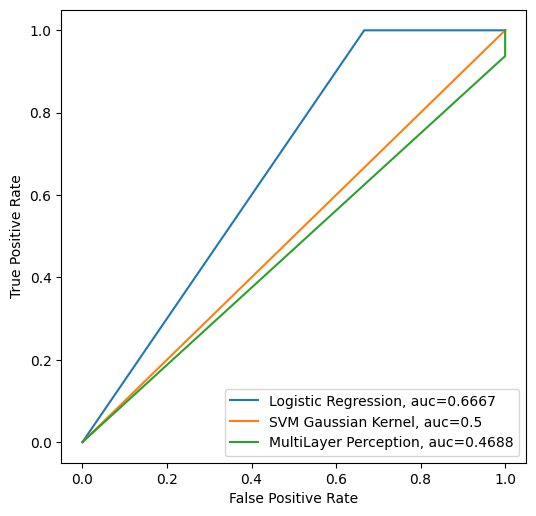

['mirlet7', 'mir145']
['PAS', 'Idade', 'obesidade']

Training on:  126
Testing on:  23
Logistic Regression
--------------------
[[ 3  3]
 [ 4 13]]
Accuracy:  69.56521739130434 %
              precision    recall  f1-score   support

           0       0.43      0.50      0.46         6
           1       0.81      0.76      0.79        17

    accuracy                           0.70        23
   macro avg       0.62      0.63      0.62        23
weighted avg       0.71      0.70      0.70        23

--------------------
SVM
--------------------
[[ 0  6]
 [ 0 17]]
Accuracy:  73.91304347826086 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.74      1.00      0.85        17

    accuracy                           0.74        23
   macro avg       0.37      0.50      0.42        23
weighted avg       0.55      0.74      0.63        23

--------------------
MultiLayer Percepton
--------------------
[[ 3  3]


<Figure size 432x288 with 0 Axes>

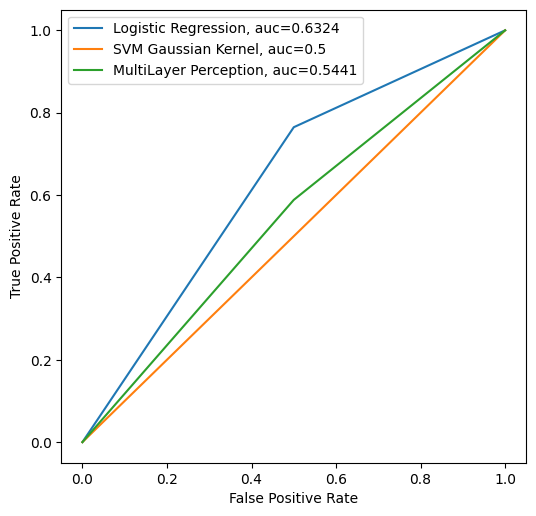

['mirlet7', 'mir145']
['PAS', 'Idade', 'IMC']

Training on:  125
Testing on:  23
Logistic Regression
--------------------
[[ 2  5]
 [ 2 14]]
Accuracy:  69.56521739130434 %
              precision    recall  f1-score   support

           0       0.50      0.29      0.36         7
           1       0.74      0.88      0.80        16

    accuracy                           0.70        23
   macro avg       0.62      0.58      0.58        23
weighted avg       0.66      0.70      0.67        23

--------------------
SVM
--------------------
[[ 0  7]
 [ 0 16]]
Accuracy:  69.56521739130434 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.70      1.00      0.82        16

    accuracy                           0.70        23
   macro avg       0.35      0.50      0.41        23
weighted avg       0.48      0.70      0.57        23

--------------------
MultiLayer Percepton
--------------------
[[ 2  5]
 [ 2 1

<Figure size 432x288 with 0 Axes>

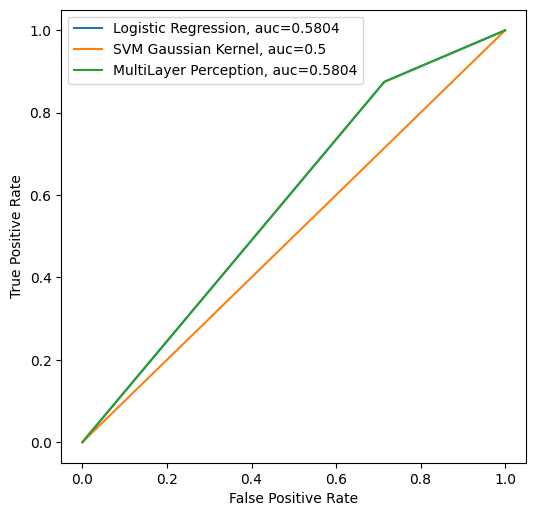

['mirlet7', 'mir145']
['Diuretico', 'IECA', 'BRA', 'IEBRA', 'betabloq', 'BCC', 'Antaaldost', 'agoalfacentral', 'agoalfaper', 'vasodilat', 'statinas', 'AAS']

Training on:  124
Testing on:  23
Logistic Regression
--------------------
[[ 2  6]
 [ 0 15]]
Accuracy:  73.91304347826086 %
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.71      1.00      0.83        15

    accuracy                           0.74        23
   macro avg       0.86      0.62      0.62        23
weighted avg       0.81      0.74      0.68        23

--------------------
SVM
--------------------
[[ 1  7]
 [ 0 15]]
Accuracy:  69.56521739130434 %
              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.68      1.00      0.81        15

    accuracy                           0.70        23
   macro avg       0.84      0.56      0.52        23
weighted avg       0.7

<Figure size 432x288 with 0 Axes>

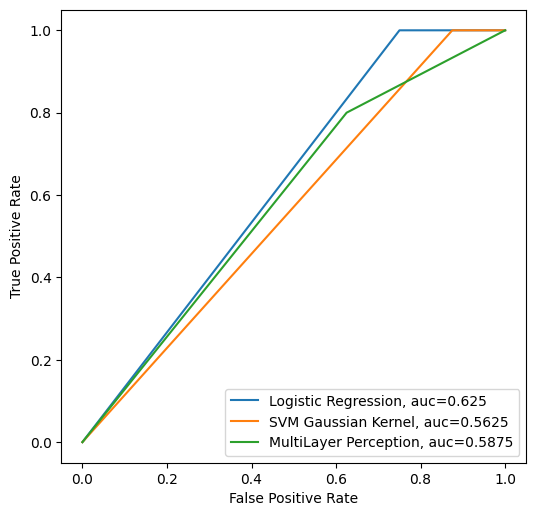

['mirlet7', 'mir145']
['Diuretico']

Training on:  126
Testing on:  23
Logistic Regression
--------------------
[[ 2  5]
 [ 0 16]]
Accuracy:  78.26086956521739 %
              precision    recall  f1-score   support

           0       1.00      0.29      0.44         7
           1       0.76      1.00      0.86        16

    accuracy                           0.78        23
   macro avg       0.88      0.64      0.65        23
weighted avg       0.83      0.78      0.74        23

--------------------
SVM
--------------------
[[ 1  6]
 [ 1 15]]
Accuracy:  69.56521739130434 %
              precision    recall  f1-score   support

           0       0.50      0.14      0.22         7
           1       0.71      0.94      0.81        16

    accuracy                           0.70        23
   macro avg       0.61      0.54      0.52        23
weighted avg       0.65      0.70      0.63        23

--------------------
MultiLayer Percepton
--------------------
[[ 3  4]
 [ 3 13]]
Accura

<Figure size 432x288 with 0 Axes>

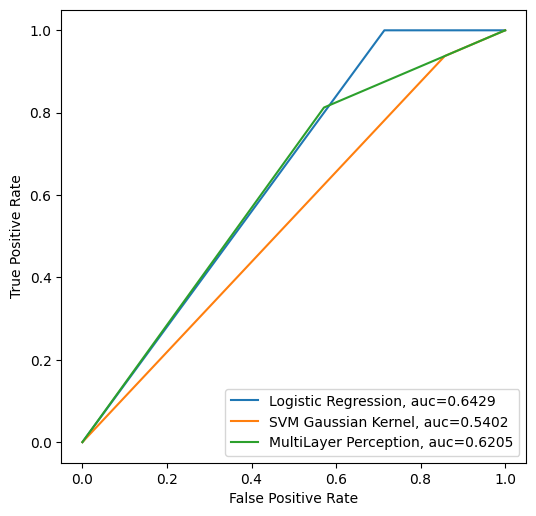

['mirlet7', 'mir145']
['IECA']

Training on:  126
Testing on:  23
Logistic Regression
--------------------
[[ 1  8]
 [ 0 14]]
Accuracy:  65.21739130434783 %
              precision    recall  f1-score   support

           0       1.00      0.11      0.20         9
           1       0.64      1.00      0.78        14

    accuracy                           0.65        23
   macro avg       0.82      0.56      0.49        23
weighted avg       0.78      0.65      0.55        23

--------------------
SVM
--------------------
[[ 1  8]
 [ 0 14]]
Accuracy:  65.21739130434783 %
              precision    recall  f1-score   support

           0       1.00      0.11      0.20         9
           1       0.64      1.00      0.78        14

    accuracy                           0.65        23
   macro avg       0.82      0.56      0.49        23
weighted avg       0.78      0.65      0.55        23

--------------------
MultiLayer Percepton
--------------------
[[ 0  9]
 [ 0 14]]
Accuracy:  

<Figure size 432x288 with 0 Axes>

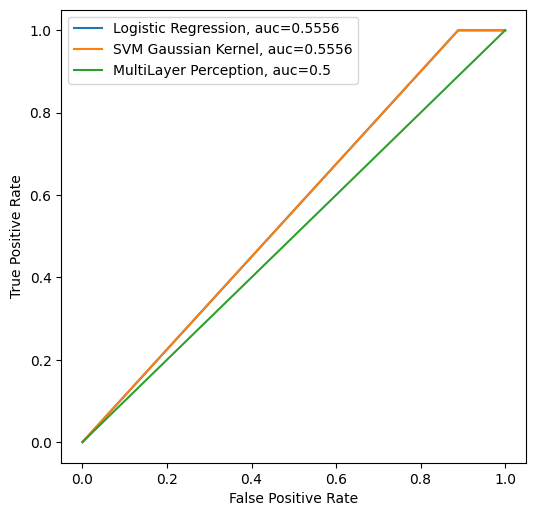

['mirlet7', 'mir145']
['BRA']

Training on:  126
Testing on:  23
Logistic Regression
--------------------
[[ 1  7]
 [ 0 15]]
Accuracy:  69.56521739130434 %
              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.68      1.00      0.81        15

    accuracy                           0.70        23
   macro avg       0.84      0.56      0.52        23
weighted avg       0.79      0.70      0.61        23

--------------------
SVM
--------------------
[[ 1  7]
 [ 0 15]]
Accuracy:  69.56521739130434 %
              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.68      1.00      0.81        15

    accuracy                           0.70        23
   macro avg       0.84      0.56      0.52        23
weighted avg       0.79      0.70      0.61        23

--------------------
MultiLayer Percepton
--------------------
[[ 2  6]
 [ 0 15]]
Accuracy:  7

<Figure size 432x288 with 0 Axes>

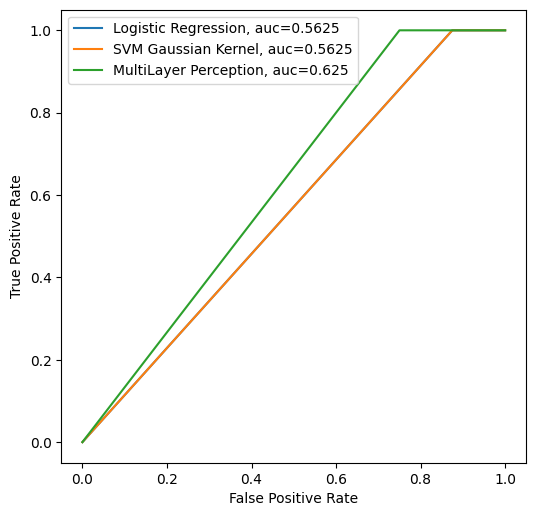

['mirlet7', 'mir145']
['IEBRA']

Training on:  126
Testing on:  23
Logistic Regression
--------------------
[[ 0  3]
 [ 1 19]]
Accuracy:  82.6086956521739 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.86      0.95      0.90        20

    accuracy                           0.83        23
   macro avg       0.43      0.47      0.45        23
weighted avg       0.75      0.83      0.79        23

--------------------
SVM
--------------------
[[ 0  3]
 [ 2 18]]
Accuracy:  78.26086956521739 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.86      0.90      0.88        20

    accuracy                           0.78        23
   macro avg       0.43      0.45      0.44        23
weighted avg       0.75      0.78      0.76        23

--------------------
MultiLayer Percepton
--------------------
[[ 0  3]
 [ 1 19]]
Accuracy:  

<Figure size 432x288 with 0 Axes>

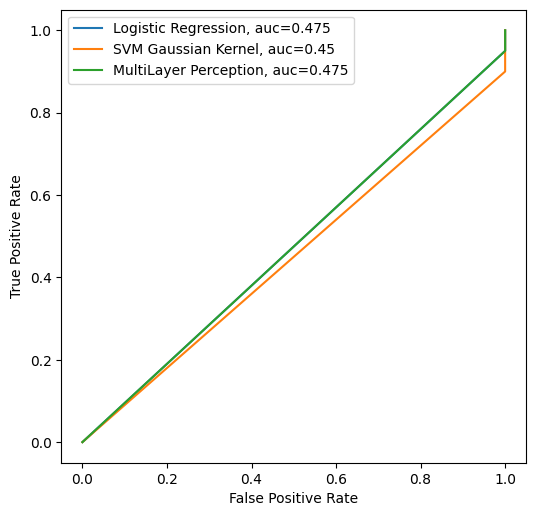

['mirlet7', 'mir145']
['betabloq']

Training on:  126
Testing on:  23
Logistic Regression
--------------------
[[ 0 10]
 [ 0 13]]
Accuracy:  56.52173913043478 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.57      1.00      0.72        13

    accuracy                           0.57        23
   macro avg       0.28      0.50      0.36        23
weighted avg       0.32      0.57      0.41        23

--------------------
SVM
--------------------
[[ 0 10]
 [ 0 13]]
Accuracy:  56.52173913043478 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.57      1.00      0.72        13

    accuracy                           0.57        23
   macro avg       0.28      0.50      0.36        23
weighted avg       0.32      0.57      0.41        23

--------------------
MultiLayer Percepton
--------------------
[[ 0 10]
 [ 0 13]]
Accurac

<Figure size 432x288 with 0 Axes>

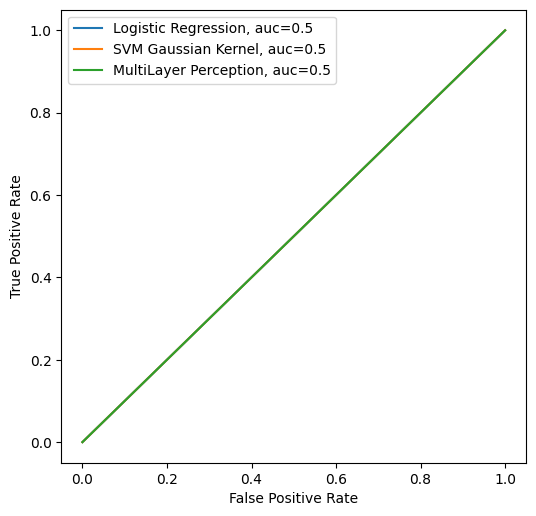

['mirlet7', 'mir145']
['BCC']

Training on:  126
Testing on:  23
Logistic Regression
--------------------
[[ 1  9]
 [ 0 13]]
Accuracy:  60.86956521739131 %
              precision    recall  f1-score   support

           0       1.00      0.10      0.18        10
           1       0.59      1.00      0.74        13

    accuracy                           0.61        23
   macro avg       0.80      0.55      0.46        23
weighted avg       0.77      0.61      0.50        23

--------------------
SVM
--------------------
[[ 2  8]
 [ 0 13]]
Accuracy:  65.21739130434783 %
              precision    recall  f1-score   support

           0       1.00      0.20      0.33        10
           1       0.62      1.00      0.76        13

    accuracy                           0.65        23
   macro avg       0.81      0.60      0.55        23
weighted avg       0.78      0.65      0.58        23

--------------------
MultiLayer Percepton
--------------------
[[ 1  9]
 [ 2 11]]
Accuracy:  5

<Figure size 432x288 with 0 Axes>

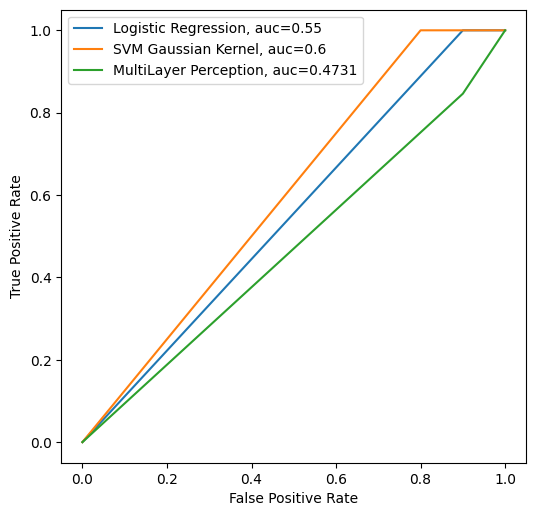

['mirlet7', 'mir145']
['Antaaldost']

Training on:  126
Testing on:  23
Logistic Regression
--------------------
[[ 0 10]
 [ 0 13]]
Accuracy:  56.52173913043478 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.57      1.00      0.72        13

    accuracy                           0.57        23
   macro avg       0.28      0.50      0.36        23
weighted avg       0.32      0.57      0.41        23

--------------------
SVM
--------------------
[[ 1  9]
 [ 0 13]]
Accuracy:  60.86956521739131 %
              precision    recall  f1-score   support

           0       1.00      0.10      0.18        10
           1       0.59      1.00      0.74        13

    accuracy                           0.61        23
   macro avg       0.80      0.55      0.46        23
weighted avg       0.77      0.61      0.50        23

--------------------
MultiLayer Percepton
--------------------
[[ 2  8]
 [ 2 11]]
Accur

<Figure size 432x288 with 0 Axes>

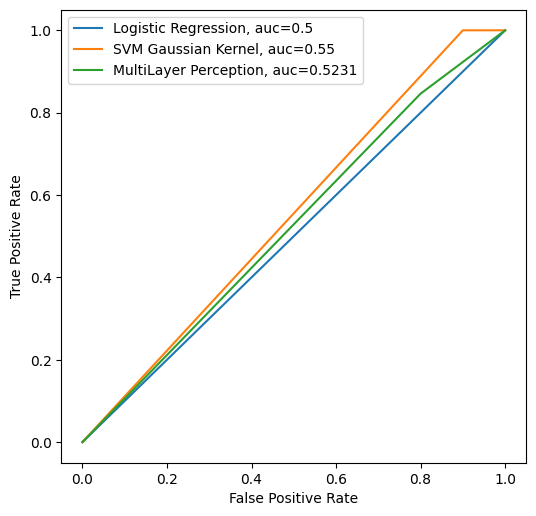

['mirlet7', 'mir145']
['agoalfacentral']

Training on:  125
Testing on:  23
Logistic Regression
--------------------
[[ 0  9]
 [ 0 14]]
Accuracy:  60.86956521739131 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.61      1.00      0.76        14

    accuracy                           0.61        23
   macro avg       0.30      0.50      0.38        23
weighted avg       0.37      0.61      0.46        23

--------------------
SVM
--------------------
[[ 2  7]
 [ 0 14]]
Accuracy:  69.56521739130434 %
              precision    recall  f1-score   support

           0       1.00      0.22      0.36         9
           1       0.67      1.00      0.80        14

    accuracy                           0.70        23
   macro avg       0.83      0.61      0.58        23
weighted avg       0.80      0.70      0.63        23

--------------------
MultiLayer Percepton
--------------------
[[ 1  8]
 [ 0 14]]
A

<Figure size 432x288 with 0 Axes>

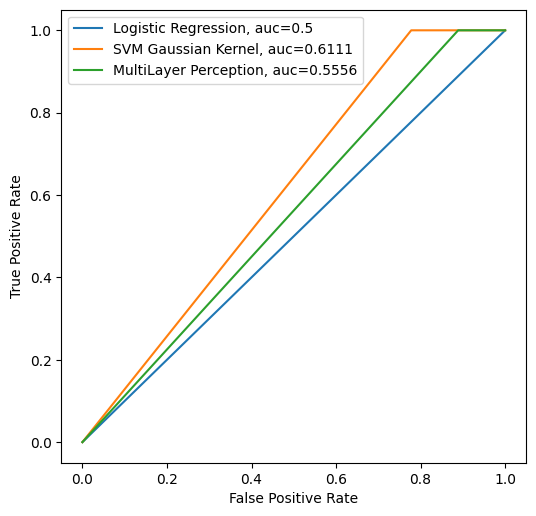

['mirlet7', 'mir145']
['agoalfaper']

Training on:  126
Testing on:  23
Logistic Regression
--------------------
[[ 1 10]
 [ 0 12]]
Accuracy:  56.52173913043478 %
              precision    recall  f1-score   support

           0       1.00      0.09      0.17        11
           1       0.55      1.00      0.71        12

    accuracy                           0.57        23
   macro avg       0.77      0.55      0.44        23
weighted avg       0.76      0.57      0.45        23

--------------------
SVM
--------------------
[[ 0 11]
 [ 0 12]]
Accuracy:  52.17391304347826 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.52      1.00      0.69        12

    accuracy                           0.52        23
   macro avg       0.26      0.50      0.34        23
weighted avg       0.27      0.52      0.36        23

--------------------
MultiLayer Percepton
--------------------
[[ 1 10]
 [ 0 12]]
Accur

<Figure size 432x288 with 0 Axes>

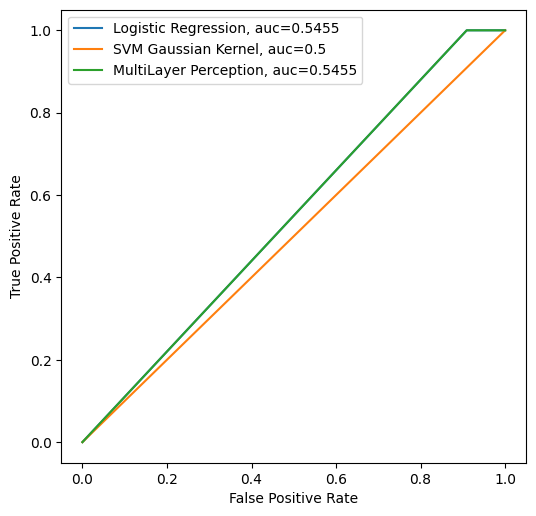

['mirlet7', 'mir145']
['vasodilat']

Training on:  125
Testing on:  23
Logistic Regression
--------------------
[[ 1  8]
 [ 0 14]]
Accuracy:  65.21739130434783 %
              precision    recall  f1-score   support

           0       1.00      0.11      0.20         9
           1       0.64      1.00      0.78        14

    accuracy                           0.65        23
   macro avg       0.82      0.56      0.49        23
weighted avg       0.78      0.65      0.55        23

--------------------
SVM
--------------------
[[ 1  8]
 [ 0 14]]
Accuracy:  65.21739130434783 %
              precision    recall  f1-score   support

           0       1.00      0.11      0.20         9
           1       0.64      1.00      0.78        14

    accuracy                           0.65        23
   macro avg       0.82      0.56      0.49        23
weighted avg       0.78      0.65      0.55        23

--------------------
MultiLayer Percepton
--------------------
[[ 2  7]
 [ 3 11]]
Accura

<Figure size 432x288 with 0 Axes>

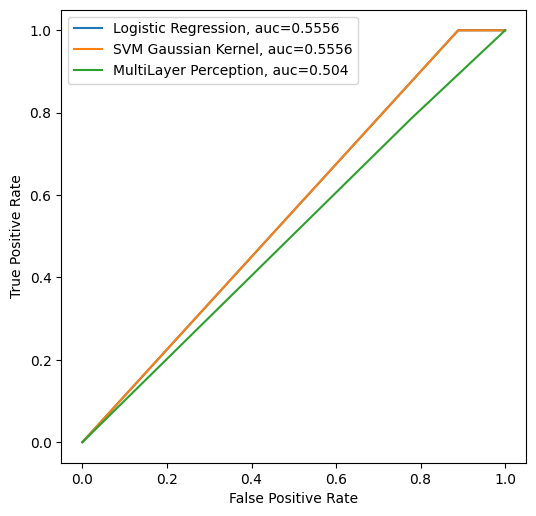

['mirlet7', 'mir145']
['statinas']

Training on:  126
Testing on:  23
Logistic Regression
--------------------
[[ 0 10]
 [ 0 13]]
Accuracy:  56.52173913043478 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.57      1.00      0.72        13

    accuracy                           0.57        23
   macro avg       0.28      0.50      0.36        23
weighted avg       0.32      0.57      0.41        23

--------------------
SVM
--------------------
[[ 1  9]
 [ 0 13]]
Accuracy:  60.86956521739131 %
              precision    recall  f1-score   support

           0       1.00      0.10      0.18        10
           1       0.59      1.00      0.74        13

    accuracy                           0.61        23
   macro avg       0.80      0.55      0.46        23
weighted avg       0.77      0.61      0.50        23

--------------------
MultiLayer Percepton
--------------------
[[ 0 10]
 [ 0 13]]
Accurac

<Figure size 432x288 with 0 Axes>

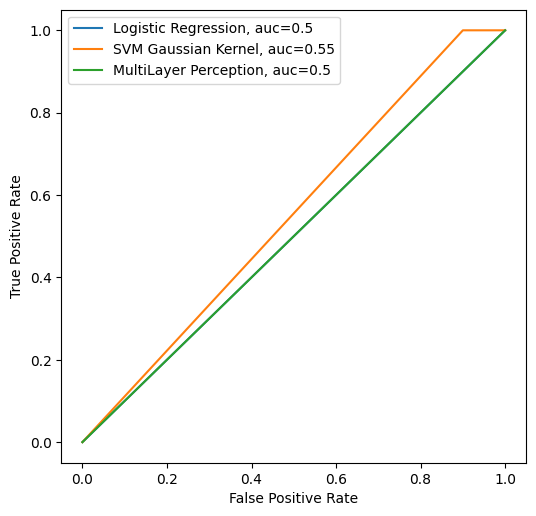

['mirlet7', 'mir145']
['AAS']

Training on:  126
Testing on:  23
Logistic Regression
--------------------
[[ 0  5]
 [ 0 18]]
Accuracy:  78.26086956521739 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.78      1.00      0.88        18

    accuracy                           0.78        23
   macro avg       0.39      0.50      0.44        23
weighted avg       0.61      0.78      0.69        23

--------------------
SVM
--------------------
[[ 0  5]
 [ 0 18]]
Accuracy:  78.26086956521739 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.78      1.00      0.88        18

    accuracy                           0.78        23
   macro avg       0.39      0.50      0.44        23
weighted avg       0.61      0.78      0.69        23

--------------------
MultiLayer Percepton
--------------------
[[ 0  5]
 [ 1 17]]
Accuracy:  7

<Figure size 432x288 with 0 Axes>

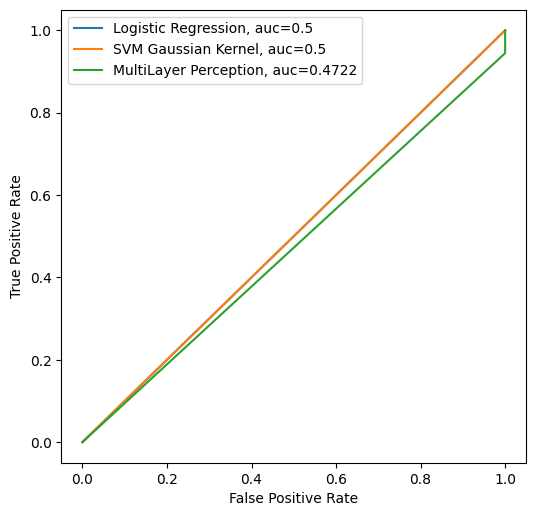

logmirlet7
['obesidade', 'Idade', 'Sexo', 'CT', 'TG', 'LDL']

Training on:  131
Testing on:  24
Logistic Regression
--------------------
[[ 1  9]
 [ 1 13]]
Accuracy:  58.333333333333336 %
              precision    recall  f1-score   support

           0       0.50      0.10      0.17        10
           1       0.59      0.93      0.72        14

    accuracy                           0.58        24
   macro avg       0.55      0.51      0.44        24
weighted avg       0.55      0.58      0.49        24

--------------------
SVM
--------------------
[[ 0 10]
 [ 0 14]]
Accuracy:  58.333333333333336 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.58      1.00      0.74        14

    accuracy                           0.58        24
   macro avg       0.29      0.50      0.37        24
weighted avg       0.34      0.58      0.43        24

--------------------
MultiLayer Percepton
-------------------

<Figure size 432x288 with 0 Axes>

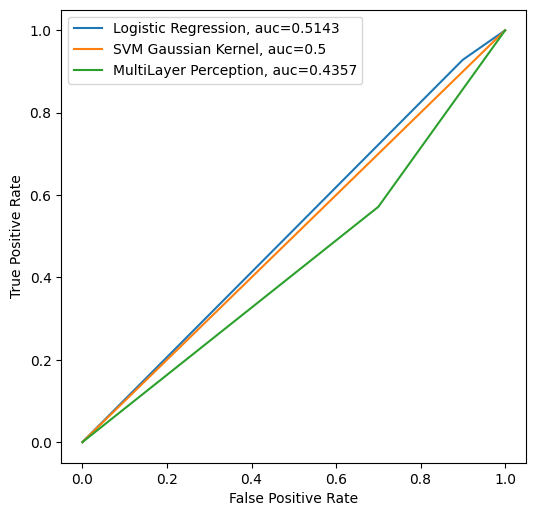

logmirlet7
['PAS', 'Idade', 'obesidade']

Training on:  134
Testing on:  24
Logistic Regression
--------------------
[[ 1  7]
 [ 1 15]]
Accuracy:  66.66666666666666 %
              precision    recall  f1-score   support

           0       0.50      0.12      0.20         8
           1       0.68      0.94      0.79        16

    accuracy                           0.67        24
   macro avg       0.59      0.53      0.49        24
weighted avg       0.62      0.67      0.59        24

--------------------
SVM
--------------------
[[ 0  8]
 [ 0 16]]
Accuracy:  66.66666666666666 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.67      1.00      0.80        16

    accuracy                           0.67        24
   macro avg       0.33      0.50      0.40        24
weighted avg       0.44      0.67      0.53        24

--------------------
MultiLayer Percepton
--------------------
[[2 6]
 [7 9]]
Accur

<Figure size 432x288 with 0 Axes>

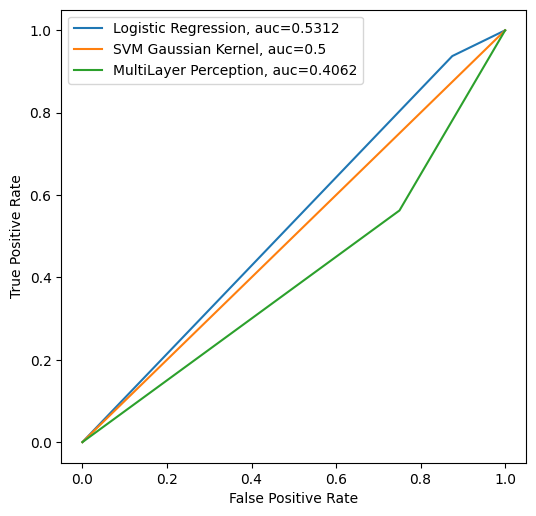

logmirlet7
['PAS', 'Idade', 'IMC']

Training on:  133
Testing on:  24
Logistic Regression
--------------------
[[ 1  5]
 [ 5 13]]
Accuracy:  58.333333333333336 %
              precision    recall  f1-score   support

           0       0.17      0.17      0.17         6
           1       0.72      0.72      0.72        18

    accuracy                           0.58        24
   macro avg       0.44      0.44      0.44        24
weighted avg       0.58      0.58      0.58        24

--------------------
SVM
--------------------
[[ 0  6]
 [ 0 18]]
Accuracy:  75.0 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.75      1.00      0.86        18

    accuracy                           0.75        24
   macro avg       0.38      0.50      0.43        24
weighted avg       0.56      0.75      0.64        24

--------------------
MultiLayer Percepton
--------------------
[[ 0  6]
 [ 7 11]]
Accuracy:  45.83333

<Figure size 432x288 with 0 Axes>

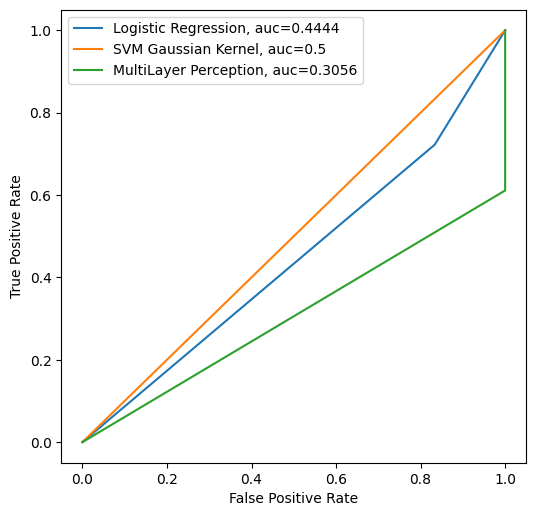

logmirlet7
['Diuretico', 'IECA', 'BRA', 'IEBRA', 'betabloq', 'BCC', 'Antaaldost', 'agoalfacentral', 'agoalfaper', 'vasodilat', 'statinas', 'AAS']

Training on:  132
Testing on:  24
Logistic Regression
--------------------
[[ 0  6]
 [ 0 18]]
Accuracy:  75.0 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.75      1.00      0.86        18

    accuracy                           0.75        24
   macro avg       0.38      0.50      0.43        24
weighted avg       0.56      0.75      0.64        24

--------------------
SVM
--------------------
[[ 0  6]
 [ 0 18]]
Accuracy:  75.0 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.75      1.00      0.86        18

    accuracy                           0.75        24
   macro avg       0.38      0.50      0.43        24
weighted avg       0.56      0.75      0.64        24

----

<Figure size 432x288 with 0 Axes>

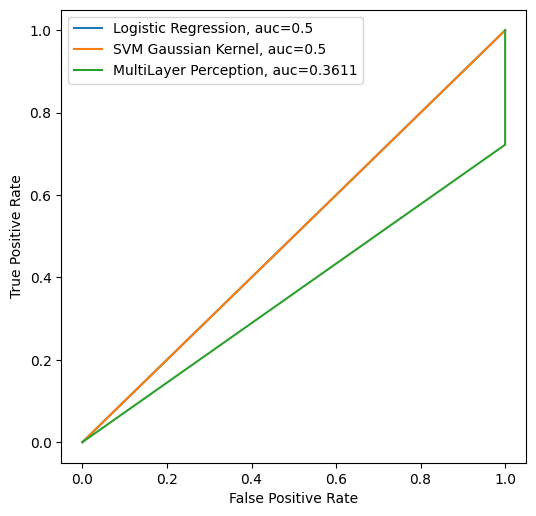

logmirlet7
['Diuretico']

Training on:  134
Testing on:  24
Logistic Regression
--------------------
[[ 0  8]
 [ 0 16]]
Accuracy:  66.66666666666666 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.67      1.00      0.80        16

    accuracy                           0.67        24
   macro avg       0.33      0.50      0.40        24
weighted avg       0.44      0.67      0.53        24

--------------------
SVM
--------------------
[[ 0  8]
 [ 0 16]]
Accuracy:  66.66666666666666 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.67      1.00      0.80        16

    accuracy                           0.67        24
   macro avg       0.33      0.50      0.40        24
weighted avg       0.44      0.67      0.53        24

--------------------
MultiLayer Percepton
--------------------
[[ 0  8]
 [ 4 12]]
Accuracy:  50.0 %

<Figure size 432x288 with 0 Axes>

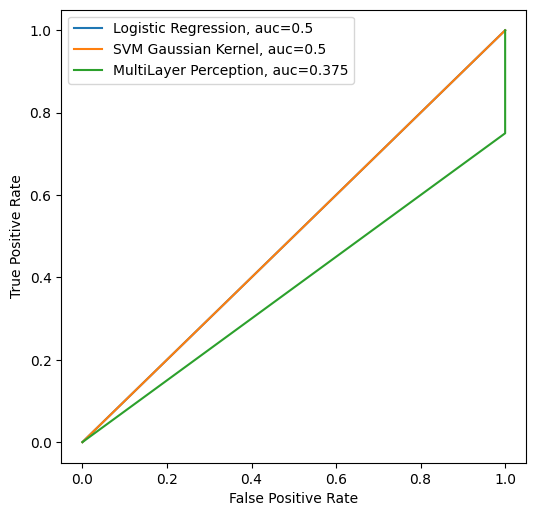

logmirlet7
['IECA']

Training on:  134
Testing on:  24
Logistic Regression
--------------------
[[ 0  5]
 [ 0 19]]
Accuracy:  79.16666666666666 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.79      1.00      0.88        19

    accuracy                           0.79        24
   macro avg       0.40      0.50      0.44        24
weighted avg       0.63      0.79      0.70        24

--------------------
SVM
--------------------
[[ 0  5]
 [ 0 19]]
Accuracy:  79.16666666666666 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.79      1.00      0.88        19

    accuracy                           0.79        24
   macro avg       0.40      0.50      0.44        24
weighted avg       0.63      0.79      0.70        24

--------------------
MultiLayer Percepton
--------------------
[[ 0  5]
 [ 2 17]]
Accuracy:  70.83333333

<Figure size 432x288 with 0 Axes>

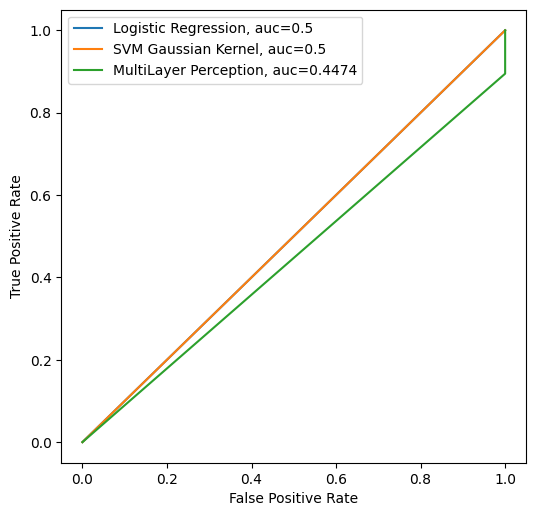

logmirlet7
['BRA']

Training on:  134
Testing on:  24
Logistic Regression
--------------------
[[ 0  7]
 [ 0 17]]
Accuracy:  70.83333333333334 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.71      1.00      0.83        17

    accuracy                           0.71        24
   macro avg       0.35      0.50      0.41        24
weighted avg       0.50      0.71      0.59        24

--------------------
SVM
--------------------
[[ 0  7]
 [ 0 17]]
Accuracy:  70.83333333333334 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.71      1.00      0.83        17

    accuracy                           0.71        24
   macro avg       0.35      0.50      0.41        24
weighted avg       0.50      0.71      0.59        24

--------------------
MultiLayer Percepton
--------------------
[[ 0  7]
 [ 1 16]]
Accuracy:  66.666666666

<Figure size 432x288 with 0 Axes>

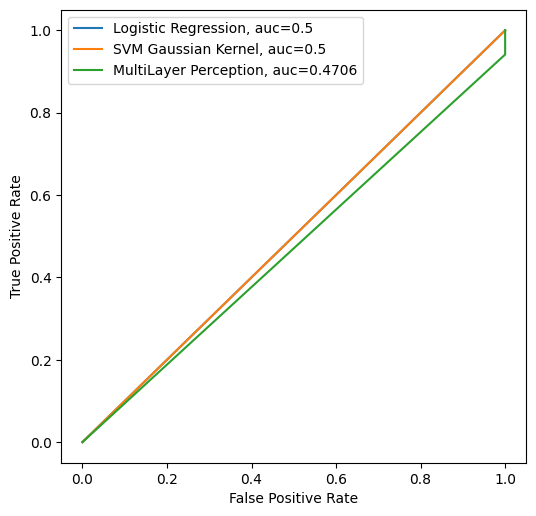

logmirlet7
['IEBRA']

Training on:  134
Testing on:  24
Logistic Regression
--------------------
[[ 0  8]
 [ 0 16]]
Accuracy:  66.66666666666666 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.67      1.00      0.80        16

    accuracy                           0.67        24
   macro avg       0.33      0.50      0.40        24
weighted avg       0.44      0.67      0.53        24

--------------------
SVM
--------------------
[[ 0  8]
 [ 0 16]]
Accuracy:  66.66666666666666 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.67      1.00      0.80        16

    accuracy                           0.67        24
   macro avg       0.33      0.50      0.40        24
weighted avg       0.44      0.67      0.53        24

--------------------
MultiLayer Percepton
--------------------
[[ 0  8]
 [ 1 15]]
Accuracy:  62.5 %
   

<Figure size 432x288 with 0 Axes>

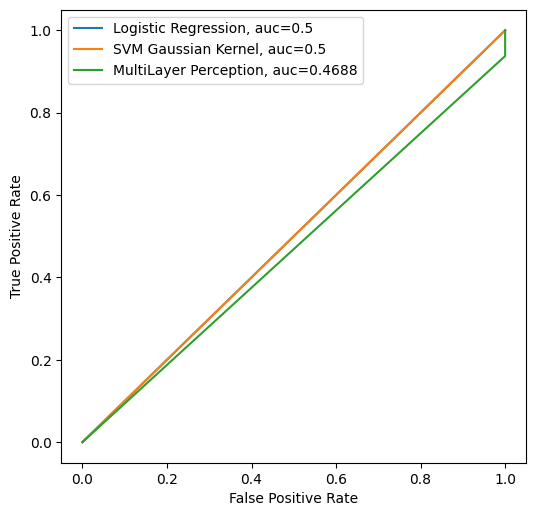

logmirlet7
['betabloq']

Training on:  134
Testing on:  24
Logistic Regression
--------------------
[[ 0  7]
 [ 0 17]]
Accuracy:  70.83333333333334 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.71      1.00      0.83        17

    accuracy                           0.71        24
   macro avg       0.35      0.50      0.41        24
weighted avg       0.50      0.71      0.59        24

--------------------
SVM
--------------------
[[ 0  7]
 [ 0 17]]
Accuracy:  70.83333333333334 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.71      1.00      0.83        17

    accuracy                           0.71        24
   macro avg       0.35      0.50      0.41        24
weighted avg       0.50      0.71      0.59        24

--------------------
MultiLayer Percepton
--------------------
[[ 1  6]
 [ 1 16]]
Accuracy:  70.8333

<Figure size 432x288 with 0 Axes>

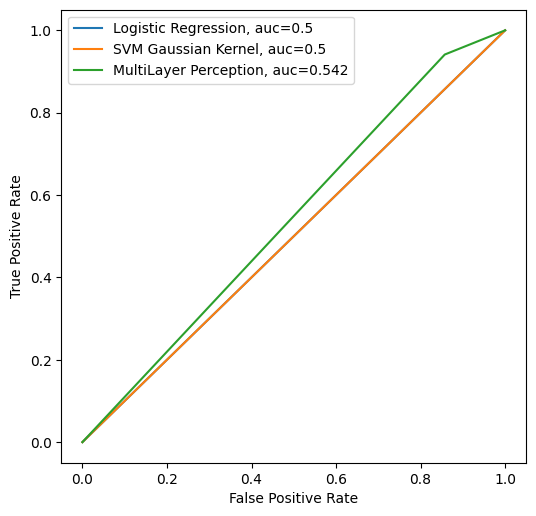

logmirlet7
['BCC']

Training on:  134
Testing on:  24
Logistic Regression
--------------------
[[ 0 10]
 [ 1 13]]
Accuracy:  54.166666666666664 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.57      0.93      0.70        14

    accuracy                           0.54        24
   macro avg       0.28      0.46      0.35        24
weighted avg       0.33      0.54      0.41        24

--------------------
SVM
--------------------
[[ 0 10]
 [ 0 14]]
Accuracy:  58.333333333333336 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.58      1.00      0.74        14

    accuracy                           0.58        24
   macro avg       0.29      0.50      0.37        24
weighted avg       0.34      0.58      0.43        24

--------------------
MultiLayer Percepton
--------------------
[[ 1  9]
 [ 0 14]]
Accuracy:  62.5 %
   

<Figure size 432x288 with 0 Axes>

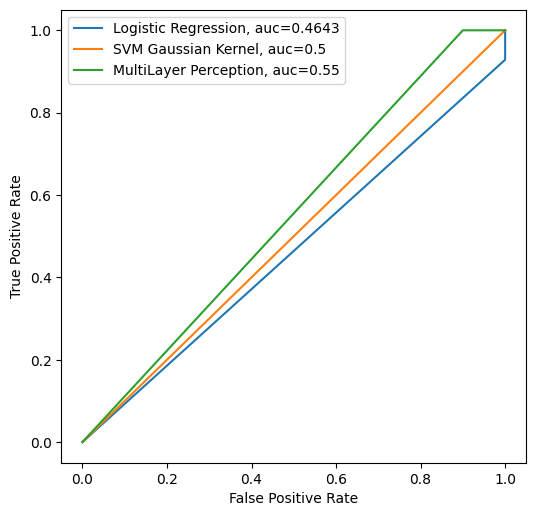

logmirlet7
['Antaaldost']

Training on:  134
Testing on:  24
Logistic Regression
--------------------
[[ 0  9]
 [ 0 15]]
Accuracy:  62.5 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.62      1.00      0.77        15

    accuracy                           0.62        24
   macro avg       0.31      0.50      0.38        24
weighted avg       0.39      0.62      0.48        24

--------------------
SVM
--------------------
[[ 0  9]
 [ 0 15]]
Accuracy:  62.5 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.62      1.00      0.77        15

    accuracy                           0.62        24
   macro avg       0.31      0.50      0.38        24
weighted avg       0.39      0.62      0.48        24

--------------------
MultiLayer Percepton
--------------------
[[ 2  7]
 [ 1 14]]
Accuracy:  66.66666666666666 %
           

<Figure size 432x288 with 0 Axes>

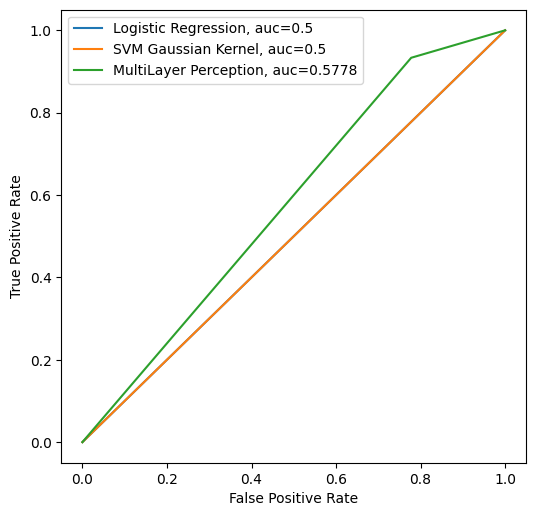

logmirlet7
['agoalfacentral']

Training on:  133
Testing on:  24
Logistic Regression
--------------------
[[ 0 10]
 [ 0 14]]
Accuracy:  58.333333333333336 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.58      1.00      0.74        14

    accuracy                           0.58        24
   macro avg       0.29      0.50      0.37        24
weighted avg       0.34      0.58      0.43        24

--------------------
SVM
--------------------
[[ 0 10]
 [ 0 14]]
Accuracy:  58.333333333333336 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.58      1.00      0.74        14

    accuracy                           0.58        24
   macro avg       0.29      0.50      0.37        24
weighted avg       0.34      0.58      0.43        24

--------------------
MultiLayer Percepton
--------------------
[[ 0 10]
 [ 1 13]]
Accuracy: 

<Figure size 432x288 with 0 Axes>

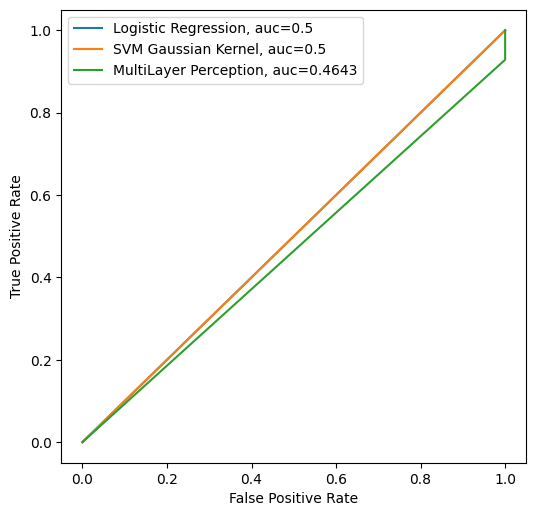

logmirlet7
['agoalfaper']

Training on:  134
Testing on:  24
Logistic Regression
--------------------
[[ 0  8]
 [ 0 16]]
Accuracy:  66.66666666666666 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.67      1.00      0.80        16

    accuracy                           0.67        24
   macro avg       0.33      0.50      0.40        24
weighted avg       0.44      0.67      0.53        24

--------------------
SVM
--------------------
[[ 0  8]
 [ 0 16]]
Accuracy:  66.66666666666666 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.67      1.00      0.80        16

    accuracy                           0.67        24
   macro avg       0.33      0.50      0.40        24
weighted avg       0.44      0.67      0.53        24

--------------------
MultiLayer Percepton
--------------------
[[ 0  8]
 [ 2 14]]
Accuracy:  58.33

<Figure size 432x288 with 0 Axes>

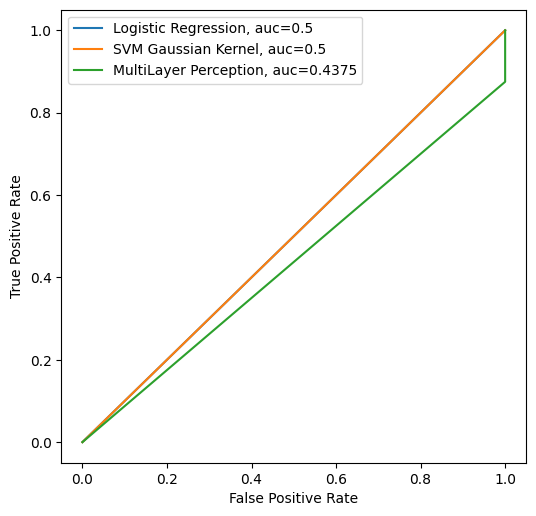

logmirlet7
['vasodilat']

Training on:  133
Testing on:  24
Logistic Regression
--------------------
[[ 0 10]
 [ 0 14]]
Accuracy:  58.333333333333336 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.58      1.00      0.74        14

    accuracy                           0.58        24
   macro avg       0.29      0.50      0.37        24
weighted avg       0.34      0.58      0.43        24

--------------------
SVM
--------------------
[[ 0 10]
 [ 0 14]]
Accuracy:  58.333333333333336 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.58      1.00      0.74        14

    accuracy                           0.58        24
   macro avg       0.29      0.50      0.37        24
weighted avg       0.34      0.58      0.43        24

--------------------
MultiLayer Percepton
--------------------
[[ 0 10]
 [ 0 14]]
Accuracy:  58.3

<Figure size 432x288 with 0 Axes>

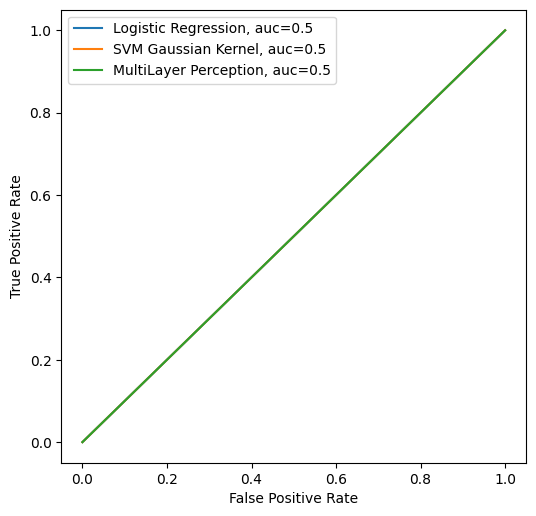

logmirlet7
['statinas']

Training on:  134
Testing on:  24
Logistic Regression
--------------------
[[ 0  9]
 [ 0 15]]
Accuracy:  62.5 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.62      1.00      0.77        15

    accuracy                           0.62        24
   macro avg       0.31      0.50      0.38        24
weighted avg       0.39      0.62      0.48        24

--------------------
SVM
--------------------
[[ 0  9]
 [ 0 15]]
Accuracy:  62.5 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.62      1.00      0.77        15

    accuracy                           0.62        24
   macro avg       0.31      0.50      0.38        24
weighted avg       0.39      0.62      0.48        24

--------------------
MultiLayer Percepton
--------------------
[[ 2  7]
 [ 1 14]]
Accuracy:  66.66666666666666 %
             

<Figure size 432x288 with 0 Axes>

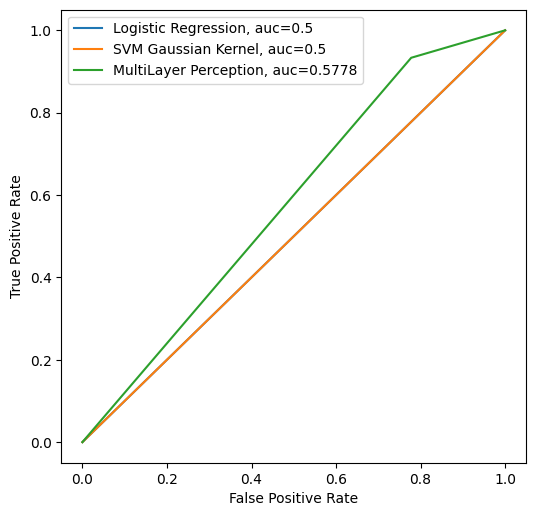

logmirlet7
['AAS']

Training on:  134
Testing on:  24
Logistic Regression
--------------------
[[ 0  9]
 [ 0 15]]
Accuracy:  62.5 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.62      1.00      0.77        15

    accuracy                           0.62        24
   macro avg       0.31      0.50      0.38        24
weighted avg       0.39      0.62      0.48        24

--------------------
SVM
--------------------
[[ 0  9]
 [ 0 15]]
Accuracy:  62.5 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.62      1.00      0.77        15

    accuracy                           0.62        24
   macro avg       0.31      0.50      0.38        24
weighted avg       0.39      0.62      0.48        24

--------------------
MultiLayer Percepton
--------------------
[[ 2  7]
 [ 3 12]]
Accuracy:  58.333333333333336 %
              pre

<Figure size 432x288 with 0 Axes>

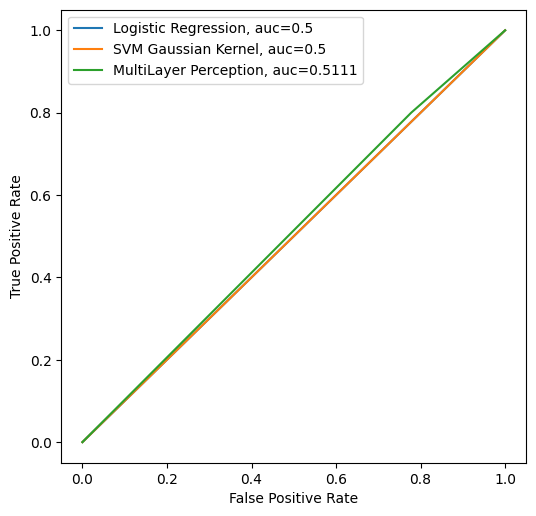

logmir145
['obesidade', 'Idade', 'Sexo', 'CT', 'TG', 'LDL']

Training on:  136
Testing on:  25
Logistic Regression
--------------------
[[ 1  9]
 [ 3 12]]
Accuracy:  52.0 %
              precision    recall  f1-score   support

           0       0.25      0.10      0.14        10
           1       0.57      0.80      0.67        15

    accuracy                           0.52        25
   macro avg       0.41      0.45      0.40        25
weighted avg       0.44      0.52      0.46        25

--------------------
SVM
--------------------
[[ 0 10]
 [ 0 15]]
Accuracy:  60.0 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.60      1.00      0.75        15

    accuracy                           0.60        25
   macro avg       0.30      0.50      0.37        25
weighted avg       0.36      0.60      0.45        25

--------------------
MultiLayer Percepton
--------------------
[[ 2  8]
 [ 5 10]]
Accuracy

<Figure size 432x288 with 0 Axes>

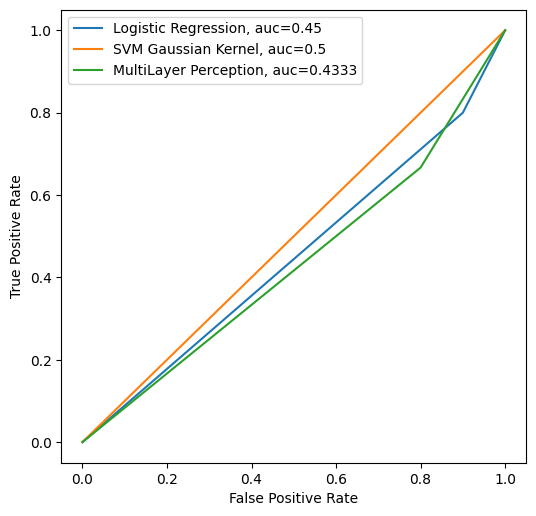

logmir145
['PAS', 'Idade', 'obesidade']

Training on:  139
Testing on:  25
Logistic Regression
--------------------
[[ 1  5]
 [ 3 16]]
Accuracy:  68.0 %
              precision    recall  f1-score   support

           0       0.25      0.17      0.20         6
           1       0.76      0.84      0.80        19

    accuracy                           0.68        25
   macro avg       0.51      0.50      0.50        25
weighted avg       0.64      0.68      0.66        25

--------------------
SVM
--------------------
[[ 0  6]
 [ 0 19]]
Accuracy:  76.0 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.76      1.00      0.86        19

    accuracy                           0.76        25
   macro avg       0.38      0.50      0.43        25
weighted avg       0.58      0.76      0.66        25

--------------------
MultiLayer Percepton
--------------------
[[ 3  3]
 [ 4 15]]
Accuracy:  72.0 %
          

<Figure size 432x288 with 0 Axes>

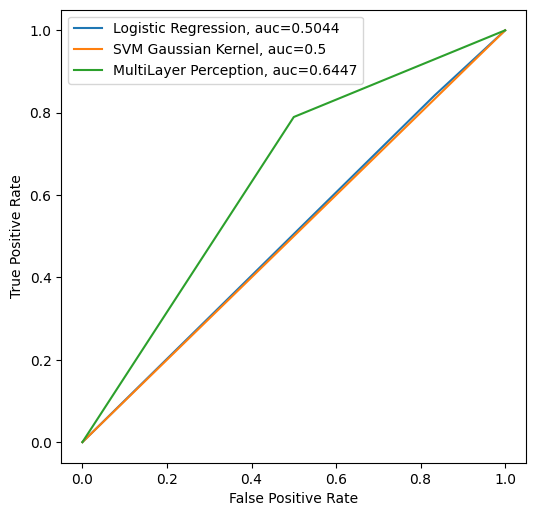

logmir145
['PAS', 'Idade', 'IMC']

Training on:  138
Testing on:  25
Logistic Regression
--------------------
[[ 2  8]
 [ 1 14]]
Accuracy:  64.0 %
              precision    recall  f1-score   support

           0       0.67      0.20      0.31        10
           1       0.64      0.93      0.76        15

    accuracy                           0.64        25
   macro avg       0.65      0.57      0.53        25
weighted avg       0.65      0.64      0.58        25

--------------------
SVM
--------------------
[[ 0 10]
 [ 0 15]]
Accuracy:  60.0 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.60      1.00      0.75        15

    accuracy                           0.60        25
   macro avg       0.30      0.50      0.37        25
weighted avg       0.36      0.60      0.45        25

--------------------
MultiLayer Percepton
--------------------
[[ 2  8]
 [ 1 14]]
Accuracy:  64.0 %
              pr

<Figure size 432x288 with 0 Axes>

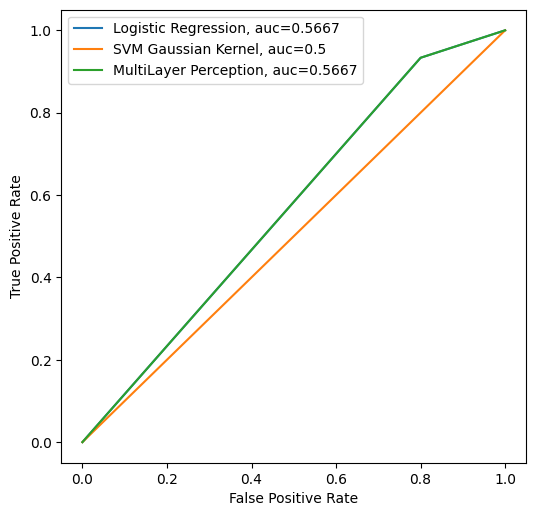

logmir145
['Diuretico', 'IECA', 'BRA', 'IEBRA', 'betabloq', 'BCC', 'Antaaldost', 'agoalfacentral', 'agoalfaper', 'vasodilat', 'statinas', 'AAS']

Training on:  137
Testing on:  25
Logistic Regression
--------------------
[[ 2  4]
 [ 0 19]]
Accuracy:  84.0 %
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         6
           1       0.83      1.00      0.90        19

    accuracy                           0.84        25
   macro avg       0.91      0.67      0.70        25
weighted avg       0.87      0.84      0.81        25

--------------------
SVM
--------------------
[[ 0  6]
 [ 0 19]]
Accuracy:  76.0 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.76      1.00      0.86        19

    accuracy                           0.76        25
   macro avg       0.38      0.50      0.43        25
weighted avg       0.58      0.76      0.66        25

-----

<Figure size 432x288 with 0 Axes>

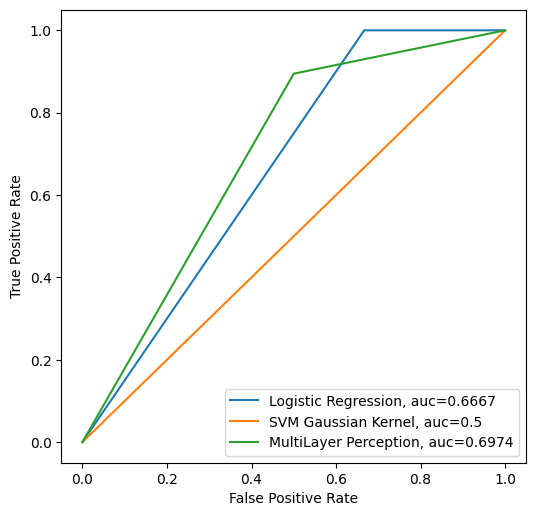

logmir145
['Diuretico']

Training on:  139
Testing on:  25
Logistic Regression
--------------------
[[ 0  7]
 [ 1 17]]
Accuracy:  68.0 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.71      0.94      0.81        18

    accuracy                           0.68        25
   macro avg       0.35      0.47      0.40        25
weighted avg       0.51      0.68      0.58        25

--------------------
SVM
--------------------
[[ 1  6]
 [ 1 17]]
Accuracy:  72.0 %
              precision    recall  f1-score   support

           0       0.50      0.14      0.22         7
           1       0.74      0.94      0.83        18

    accuracy                           0.72        25
   macro avg       0.62      0.54      0.53        25
weighted avg       0.67      0.72      0.66        25

--------------------
MultiLayer Percepton
--------------------
[[ 0  7]
 [ 0 18]]
Accuracy:  72.0 %
              precision   

<Figure size 432x288 with 0 Axes>

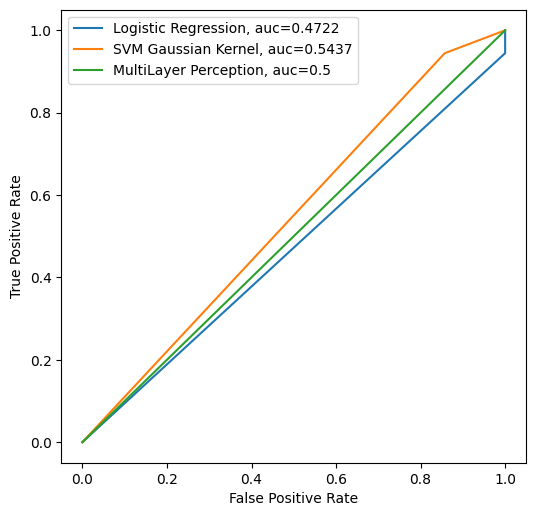

logmir145
['IECA']

Training on:  139
Testing on:  25
Logistic Regression
--------------------
[[ 0  7]
 [ 0 18]]
Accuracy:  72.0 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.72      1.00      0.84        18

    accuracy                           0.72        25
   macro avg       0.36      0.50      0.42        25
weighted avg       0.52      0.72      0.60        25

--------------------
SVM
--------------------
[[ 2  5]
 [ 0 18]]
Accuracy:  80.0 %
              precision    recall  f1-score   support

           0       1.00      0.29      0.44         7
           1       0.78      1.00      0.88        18

    accuracy                           0.80        25
   macro avg       0.89      0.64      0.66        25
weighted avg       0.84      0.80      0.76        25

--------------------
MultiLayer Percepton
--------------------
[[ 0  7]
 [ 0 18]]
Accuracy:  72.0 %
              precision    reca

<Figure size 432x288 with 0 Axes>

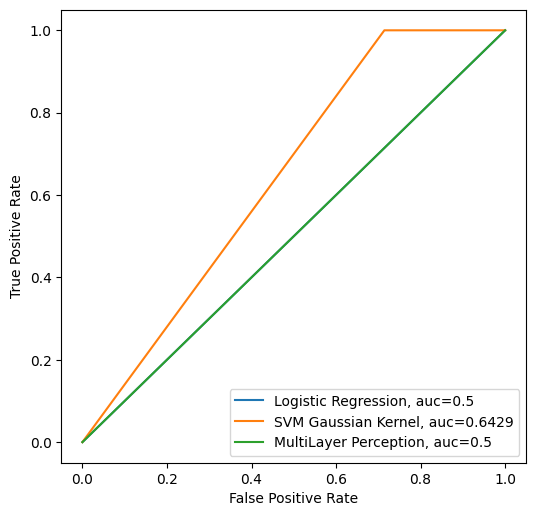

logmir145
['BRA']

Training on:  139
Testing on:  25
Logistic Regression
--------------------
[[ 0 11]
 [ 0 14]]
Accuracy:  56.00000000000001 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.56      1.00      0.72        14

    accuracy                           0.56        25
   macro avg       0.28      0.50      0.36        25
weighted avg       0.31      0.56      0.40        25

--------------------
SVM
--------------------
[[ 0 11]
 [ 0 14]]
Accuracy:  56.00000000000001 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.56      1.00      0.72        14

    accuracy                           0.56        25
   macro avg       0.28      0.50      0.36        25
weighted avg       0.31      0.56      0.40        25

--------------------
MultiLayer Percepton
--------------------
[[ 0 11]
 [ 0 14]]
Accuracy:  56.0000000000

<Figure size 432x288 with 0 Axes>

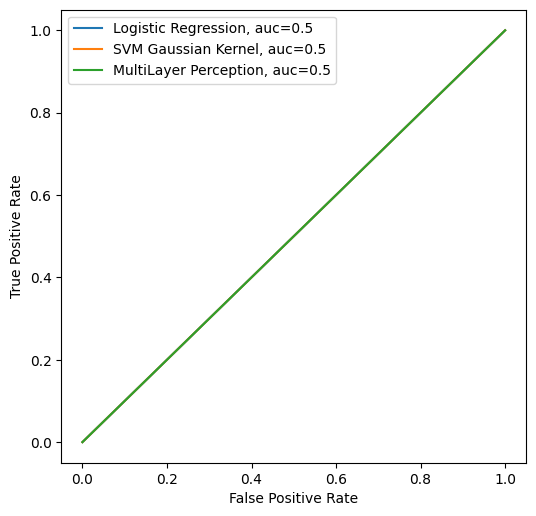

logmir145
['IEBRA']

Training on:  139
Testing on:  25
Logistic Regression
--------------------
[[ 1  5]
 [ 0 19]]
Accuracy:  80.0 %
              precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.79      1.00      0.88        19

    accuracy                           0.80        25
   macro avg       0.90      0.58      0.58        25
weighted avg       0.84      0.80      0.74        25

--------------------
SVM
--------------------
[[ 1  5]
 [ 0 19]]
Accuracy:  80.0 %
              precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.79      1.00      0.88        19

    accuracy                           0.80        25
   macro avg       0.90      0.58      0.58        25
weighted avg       0.84      0.80      0.74        25

--------------------
MultiLayer Percepton
--------------------
[[ 1  5]
 [ 0 19]]
Accuracy:  80.0 %
              precision    rec

<Figure size 432x288 with 0 Axes>

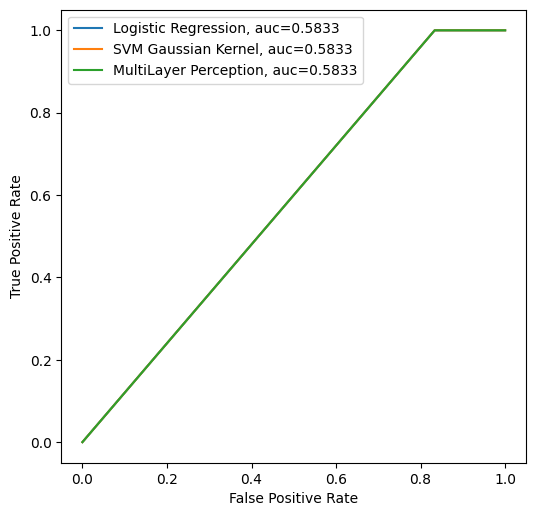

logmir145
['betabloq']

Training on:  139
Testing on:  25
Logistic Regression
--------------------
[[ 0  7]
 [ 1 17]]
Accuracy:  68.0 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.71      0.94      0.81        18

    accuracy                           0.68        25
   macro avg       0.35      0.47      0.40        25
weighted avg       0.51      0.68      0.58        25

--------------------
SVM
--------------------
[[ 0  7]
 [ 1 17]]
Accuracy:  68.0 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.71      0.94      0.81        18

    accuracy                           0.68        25
   macro avg       0.35      0.47      0.40        25
weighted avg       0.51      0.68      0.58        25

--------------------
MultiLayer Percepton
--------------------
[[ 0  7]
 [ 1 17]]
Accuracy:  68.0 %
              precision    

<Figure size 432x288 with 0 Axes>

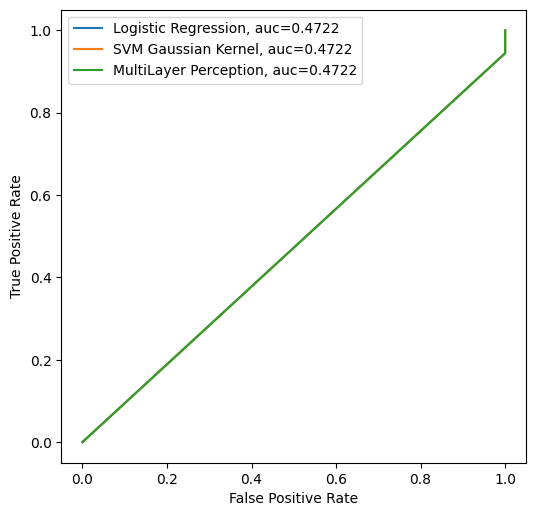

logmir145
['BCC']

Training on:  139
Testing on:  25
Logistic Regression
--------------------
[[ 2  6]
 [ 0 17]]
Accuracy:  76.0 %
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.74      1.00      0.85        17

    accuracy                           0.76        25
   macro avg       0.87      0.62      0.62        25
weighted avg       0.82      0.76      0.71        25

--------------------
SVM
--------------------
[[ 2  6]
 [ 0 17]]
Accuracy:  76.0 %
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.74      1.00      0.85        17

    accuracy                           0.76        25
   macro avg       0.87      0.62      0.62        25
weighted avg       0.82      0.76      0.71        25

--------------------
MultiLayer Percepton
--------------------
[[ 3  5]
 [ 0 17]]
Accuracy:  80.0 %
              precision    recal

<Figure size 432x288 with 0 Axes>

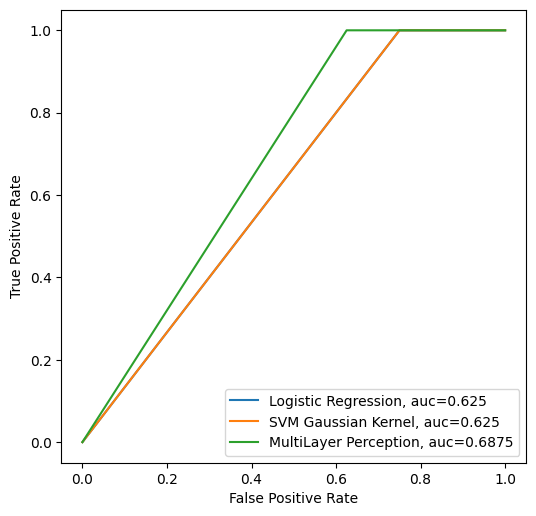

logmir145
['Antaaldost']

Training on:  139
Testing on:  25
Logistic Regression
--------------------
[[ 0  6]
 [ 0 19]]
Accuracy:  76.0 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.76      1.00      0.86        19

    accuracy                           0.76        25
   macro avg       0.38      0.50      0.43        25
weighted avg       0.58      0.76      0.66        25

--------------------
SVM
--------------------
[[ 2  4]
 [ 0 19]]
Accuracy:  84.0 %
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         6
           1       0.83      1.00      0.90        19

    accuracy                           0.84        25
   macro avg       0.91      0.67      0.70        25
weighted avg       0.87      0.84      0.81        25

--------------------
MultiLayer Percepton
--------------------
[[ 2  4]
 [ 1 18]]
Accuracy:  80.0 %
              precision  

<Figure size 432x288 with 0 Axes>

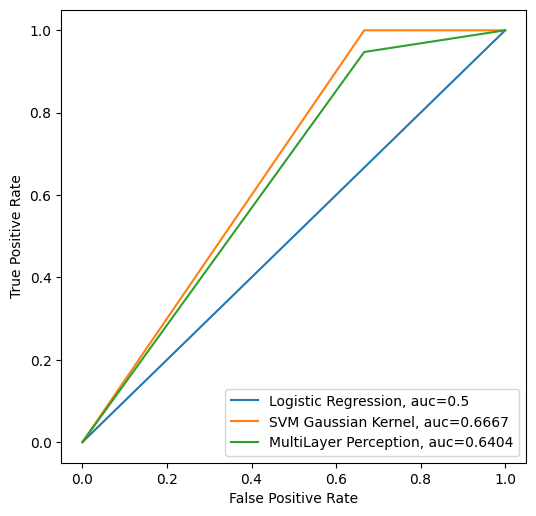

logmir145
['agoalfacentral']

Training on:  138
Testing on:  25
Logistic Regression
--------------------
[[ 0  6]
 [ 0 19]]
Accuracy:  76.0 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.76      1.00      0.86        19

    accuracy                           0.76        25
   macro avg       0.38      0.50      0.43        25
weighted avg       0.58      0.76      0.66        25

--------------------
SVM
--------------------
[[ 0  6]
 [ 0 19]]
Accuracy:  76.0 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.76      1.00      0.86        19

    accuracy                           0.76        25
   macro avg       0.38      0.50      0.43        25
weighted avg       0.58      0.76      0.66        25

--------------------
MultiLayer Percepton
--------------------
[[ 0  6]
 [ 0 19]]
Accuracy:  76.0 %
              precisi

<Figure size 432x288 with 0 Axes>

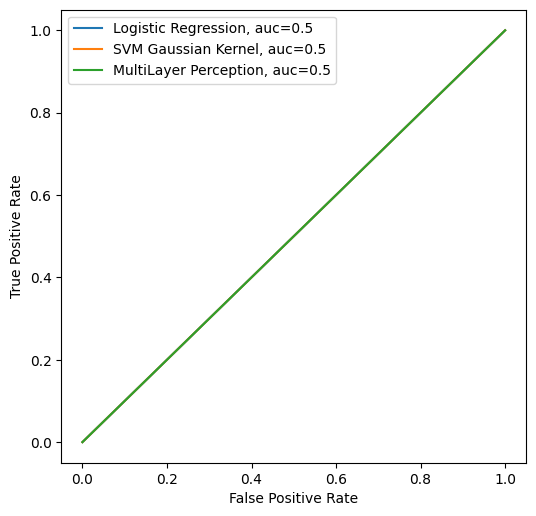

logmir145
['agoalfaper']

Training on:  139
Testing on:  25
Logistic Regression
--------------------
[[ 0 10]
 [ 1 14]]
Accuracy:  56.00000000000001 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.58      0.93      0.72        15

    accuracy                           0.56        25
   macro avg       0.29      0.47      0.36        25
weighted avg       0.35      0.56      0.43        25

--------------------
SVM
--------------------
[[ 3  7]
 [ 2 13]]
Accuracy:  64.0 %
              precision    recall  f1-score   support

           0       0.60      0.30      0.40        10
           1       0.65      0.87      0.74        15

    accuracy                           0.64        25
   macro avg       0.62      0.58      0.57        25
weighted avg       0.63      0.64      0.61        25

--------------------
MultiLayer Percepton
--------------------
[[ 3  7]
 [ 1 14]]
Accuracy:  68.0 %
            

<Figure size 432x288 with 0 Axes>

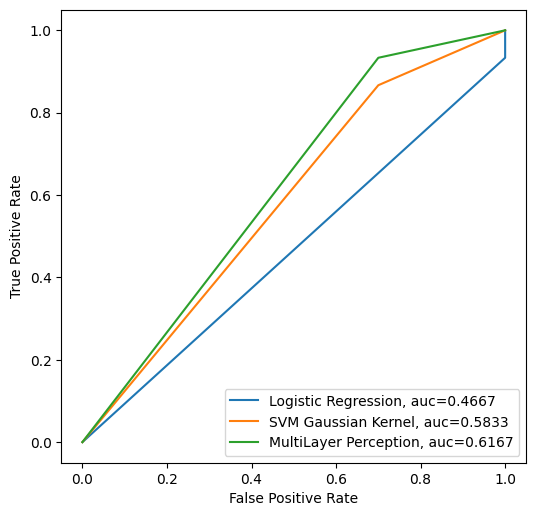

logmir145
['vasodilat']

Training on:  138
Testing on:  25
Logistic Regression
--------------------
[[ 1 10]
 [ 0 14]]
Accuracy:  60.0 %
              precision    recall  f1-score   support

           0       1.00      0.09      0.17        11
           1       0.58      1.00      0.74        14

    accuracy                           0.60        25
   macro avg       0.79      0.55      0.45        25
weighted avg       0.77      0.60      0.49        25

--------------------
SVM
--------------------
[[ 1 10]
 [ 2 12]]
Accuracy:  52.0 %
              precision    recall  f1-score   support

           0       0.33      0.09      0.14        11
           1       0.55      0.86      0.67        14

    accuracy                           0.52        25
   macro avg       0.44      0.47      0.40        25
weighted avg       0.45      0.52      0.44        25

--------------------
MultiLayer Percepton
--------------------
[[ 1 10]
 [ 2 12]]
Accuracy:  52.0 %
              precision   

<Figure size 432x288 with 0 Axes>

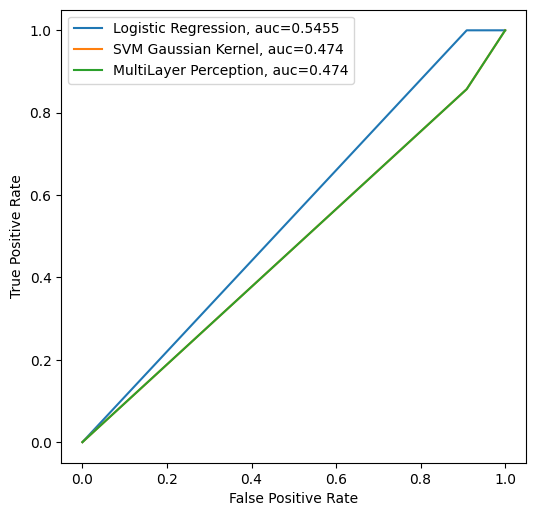

logmir145
['statinas']

Training on:  139
Testing on:  25
Logistic Regression
--------------------
[[ 2  9]
 [ 3 11]]
Accuracy:  52.0 %
              precision    recall  f1-score   support

           0       0.40      0.18      0.25        11
           1       0.55      0.79      0.65        14

    accuracy                           0.52        25
   macro avg       0.48      0.48      0.45        25
weighted avg       0.48      0.52      0.47        25

--------------------
SVM
--------------------
[[ 2  9]
 [ 3 11]]
Accuracy:  52.0 %
              precision    recall  f1-score   support

           0       0.40      0.18      0.25        11
           1       0.55      0.79      0.65        14

    accuracy                           0.52        25
   macro avg       0.48      0.48      0.45        25
weighted avg       0.48      0.52      0.47        25

--------------------
MultiLayer Percepton
--------------------
[[ 2  9]
 [ 3 11]]
Accuracy:  52.0 %
              precision    

<Figure size 432x288 with 0 Axes>

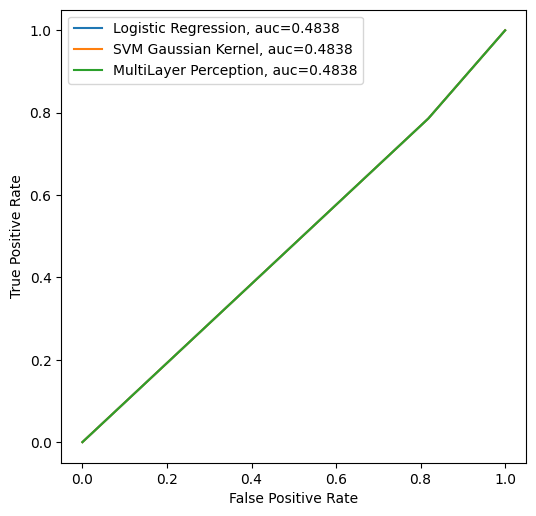

logmir145
['AAS']

Training on:  139
Testing on:  25
Logistic Regression
--------------------
[[ 1  7]
 [ 1 16]]
Accuracy:  68.0 %
              precision    recall  f1-score   support

           0       0.50      0.12      0.20         8
           1       0.70      0.94      0.80        17

    accuracy                           0.68        25
   macro avg       0.60      0.53      0.50        25
weighted avg       0.63      0.68      0.61        25

--------------------
SVM
--------------------
[[ 3  5]
 [ 2 15]]
Accuracy:  72.0 %
              precision    recall  f1-score   support

           0       0.60      0.38      0.46         8
           1       0.75      0.88      0.81        17

    accuracy                           0.72        25
   macro avg       0.68      0.63      0.64        25
weighted avg       0.70      0.72      0.70        25

--------------------
MultiLayer Percepton
--------------------
[[ 2  6]
 [ 2 15]]
Accuracy:  68.0 %
              precision    recal

<Figure size 432x288 with 0 Axes>

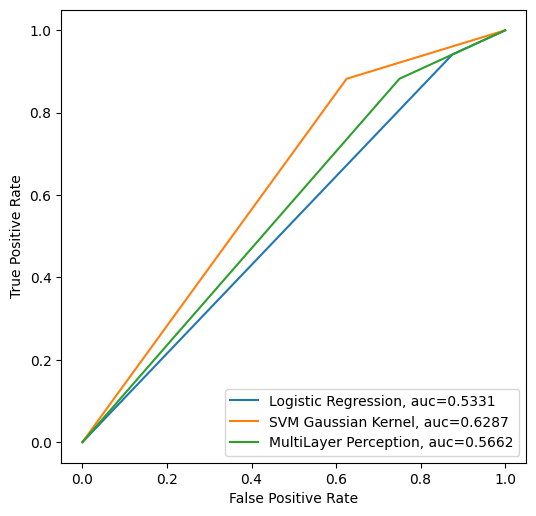

['logmirlet7', 'logmir145']
['obesidade', 'Idade', 'Sexo', 'CT', 'TG', 'LDL']

Training on:  124
Testing on:  22
Logistic Regression
--------------------
[[ 2  8]
 [ 1 11]]
Accuracy:  59.09090909090909 %
              precision    recall  f1-score   support

           0       0.67      0.20      0.31        10
           1       0.58      0.92      0.71        12

    accuracy                           0.59        22
   macro avg       0.62      0.56      0.51        22
weighted avg       0.62      0.59      0.53        22

--------------------
SVM
--------------------
[[ 0 10]
 [ 0 12]]
Accuracy:  54.54545454545454 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.55      1.00      0.71        12

    accuracy                           0.55        22
   macro avg       0.27      0.50      0.35        22
weighted avg       0.30      0.55      0.39        22

--------------------
MultiLayer Percepton
----

<Figure size 432x288 with 0 Axes>

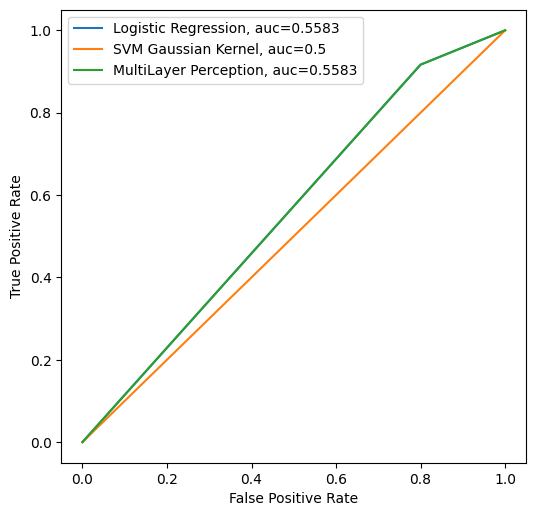

['logmirlet7', 'logmir145']
['PAS', 'Idade', 'obesidade']

Training on:  126
Testing on:  23
Logistic Regression
--------------------
[[ 1  7]
 [ 0 15]]
Accuracy:  69.56521739130434 %
              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.68      1.00      0.81        15

    accuracy                           0.70        23
   macro avg       0.84      0.56      0.52        23
weighted avg       0.79      0.70      0.61        23

--------------------
SVM
--------------------
[[ 0  8]
 [ 0 15]]
Accuracy:  65.21739130434783 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.65      1.00      0.79        15

    accuracy                           0.65        23
   macro avg       0.33      0.50      0.39        23
weighted avg       0.43      0.65      0.51        23

--------------------
MultiLayer Percepton
--------------------
[[ 

<Figure size 432x288 with 0 Axes>

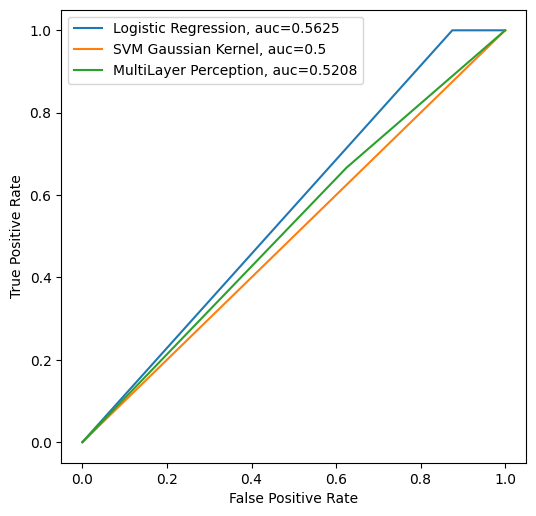

['logmirlet7', 'logmir145']
['PAS', 'Idade', 'IMC']

Training on:  125
Testing on:  23
Logistic Regression
--------------------
[[ 2  8]
 [ 3 10]]
Accuracy:  52.17391304347826 %
              precision    recall  f1-score   support

           0       0.40      0.20      0.27        10
           1       0.56      0.77      0.65        13

    accuracy                           0.52        23
   macro avg       0.48      0.48      0.46        23
weighted avg       0.49      0.52      0.48        23

--------------------
SVM
--------------------
[[ 0 10]
 [ 0 13]]
Accuracy:  56.52173913043478 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.57      1.00      0.72        13

    accuracy                           0.57        23
   macro avg       0.28      0.50      0.36        23
weighted avg       0.32      0.57      0.41        23

--------------------
MultiLayer Percepton
--------------------
[[4 6]
 [

<Figure size 432x288 with 0 Axes>

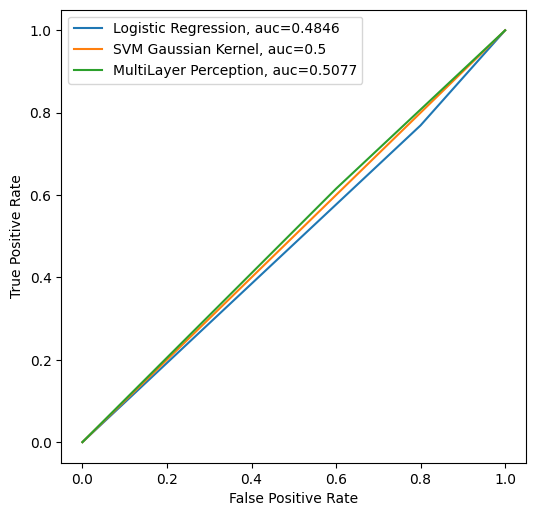

['logmirlet7', 'logmir145']
['Diuretico', 'IECA', 'BRA', 'IEBRA', 'betabloq', 'BCC', 'Antaaldost', 'agoalfacentral', 'agoalfaper', 'vasodilat', 'statinas', 'AAS']

Training on:  124
Testing on:  23
Logistic Regression
--------------------
[[ 0  8]
 [ 1 14]]
Accuracy:  60.86956521739131 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.64      0.93      0.76        15

    accuracy                           0.61        23
   macro avg       0.32      0.47      0.38        23
weighted avg       0.42      0.61      0.49        23

--------------------
SVM
--------------------
[[ 0  8]
 [ 0 15]]
Accuracy:  65.21739130434783 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.65      1.00      0.79        15

    accuracy                           0.65        23
   macro avg       0.33      0.50      0.39        23
weighted avg    

<Figure size 432x288 with 0 Axes>

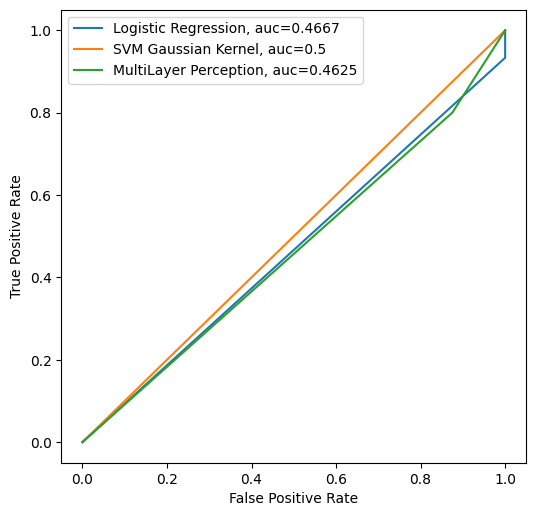

['logmirlet7', 'logmir145']
['Diuretico']

Training on:  126
Testing on:  23
Logistic Regression
--------------------
[[ 0  9]
 [ 0 14]]
Accuracy:  60.86956521739131 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.61      1.00      0.76        14

    accuracy                           0.61        23
   macro avg       0.30      0.50      0.38        23
weighted avg       0.37      0.61      0.46        23

--------------------
SVM
--------------------
[[ 0  9]
 [ 0 14]]
Accuracy:  60.86956521739131 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.61      1.00      0.76        14

    accuracy                           0.61        23
   macro avg       0.30      0.50      0.38        23
weighted avg       0.37      0.61      0.46        23

--------------------
MultiLayer Percepton
--------------------
[[ 2  7]
 [ 4 10]]


<Figure size 432x288 with 0 Axes>

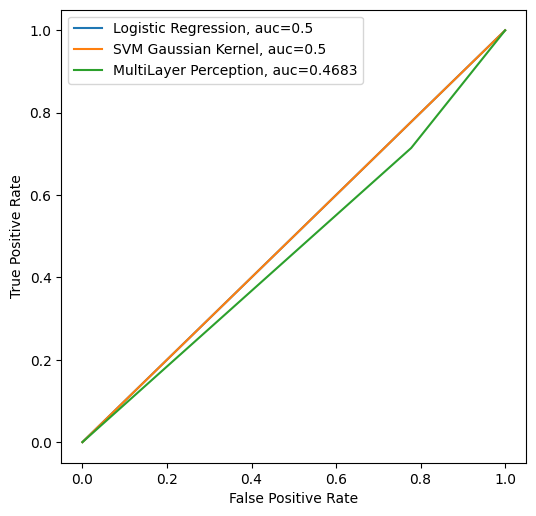

['logmirlet7', 'logmir145']
['IECA']

Training on:  126
Testing on:  23
Logistic Regression
--------------------
[[ 1  6]
 [ 2 14]]
Accuracy:  65.21739130434783 %
              precision    recall  f1-score   support

           0       0.33      0.14      0.20         7
           1       0.70      0.88      0.78        16

    accuracy                           0.65        23
   macro avg       0.52      0.51      0.49        23
weighted avg       0.59      0.65      0.60        23

--------------------
SVM
--------------------
[[ 1  6]
 [ 0 16]]
Accuracy:  73.91304347826086 %
              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.73      1.00      0.84        16

    accuracy                           0.74        23
   macro avg       0.86      0.57      0.55        23
weighted avg       0.81      0.74      0.66        23

--------------------
MultiLayer Percepton
--------------------
[[ 1  6]
 [ 2 14]]
Accur

<Figure size 432x288 with 0 Axes>

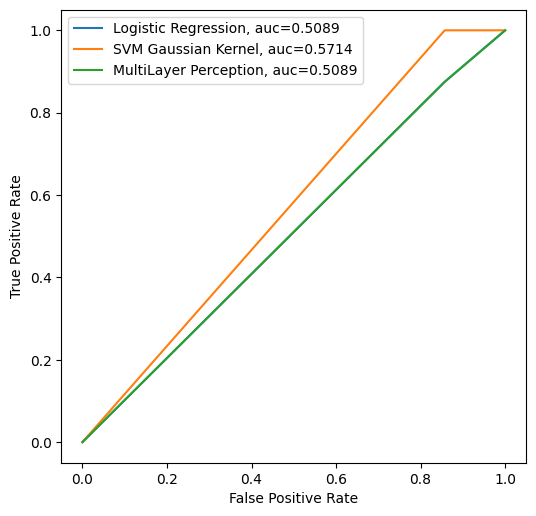

['logmirlet7', 'logmir145']
['BRA']

Training on:  126
Testing on:  23
Logistic Regression
--------------------
[[ 0  6]
 [ 0 17]]
Accuracy:  73.91304347826086 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.74      1.00      0.85        17

    accuracy                           0.74        23
   macro avg       0.37      0.50      0.42        23
weighted avg       0.55      0.74      0.63        23

--------------------
SVM
--------------------
[[ 0  6]
 [ 0 17]]
Accuracy:  73.91304347826086 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.74      1.00      0.85        17

    accuracy                           0.74        23
   macro avg       0.37      0.50      0.42        23
weighted avg       0.55      0.74      0.63        23

--------------------
MultiLayer Percepton
--------------------
[[ 0  6]
 [ 2 15]]
Accura

<Figure size 432x288 with 0 Axes>

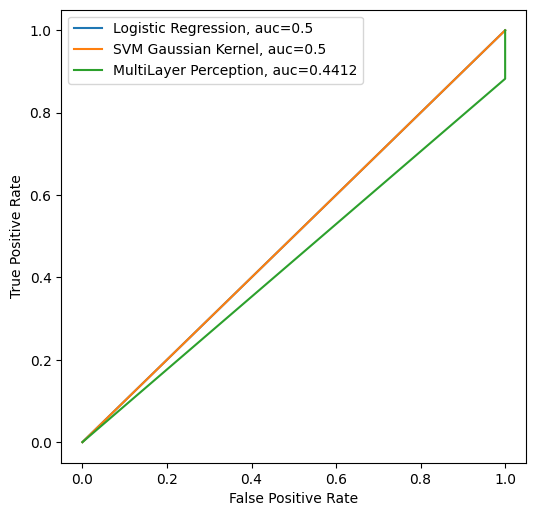

['logmirlet7', 'logmir145']
['IEBRA']

Training on:  126
Testing on:  23
Logistic Regression
--------------------
[[ 1  6]
 [ 0 16]]
Accuracy:  73.91304347826086 %
              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.73      1.00      0.84        16

    accuracy                           0.74        23
   macro avg       0.86      0.57      0.55        23
weighted avg       0.81      0.74      0.66        23

--------------------
SVM
--------------------
[[ 1  6]
 [ 0 16]]
Accuracy:  73.91304347826086 %
              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.73      1.00      0.84        16

    accuracy                           0.74        23
   macro avg       0.86      0.57      0.55        23
weighted avg       0.81      0.74      0.66        23

--------------------
MultiLayer Percepton
--------------------
[[ 1  6]
 [ 0 16]]
Accu

<Figure size 432x288 with 0 Axes>

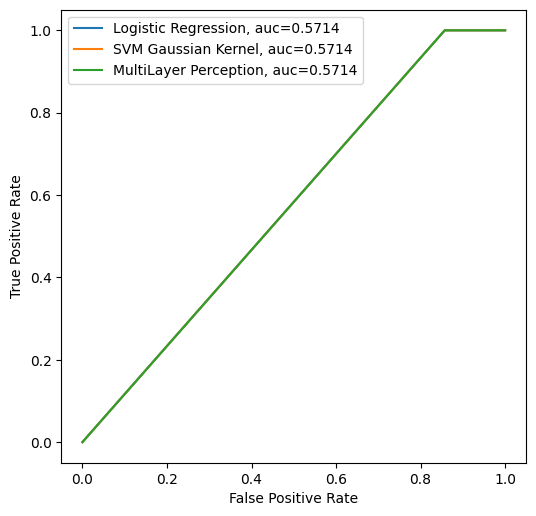

['logmirlet7', 'logmir145']
['betabloq']

Training on:  126
Testing on:  23
Logistic Regression
--------------------
[[ 2  7]
 [ 0 14]]
Accuracy:  69.56521739130434 %
              precision    recall  f1-score   support

           0       1.00      0.22      0.36         9
           1       0.67      1.00      0.80        14

    accuracy                           0.70        23
   macro avg       0.83      0.61      0.58        23
weighted avg       0.80      0.70      0.63        23

--------------------
SVM
--------------------
[[ 1  8]
 [ 0 14]]
Accuracy:  65.21739130434783 %
              precision    recall  f1-score   support

           0       1.00      0.11      0.20         9
           1       0.64      1.00      0.78        14

    accuracy                           0.65        23
   macro avg       0.82      0.56      0.49        23
weighted avg       0.78      0.65      0.55        23

--------------------
MultiLayer Percepton
--------------------
[[ 2  7]
 [ 1 13]]
A

<Figure size 432x288 with 0 Axes>

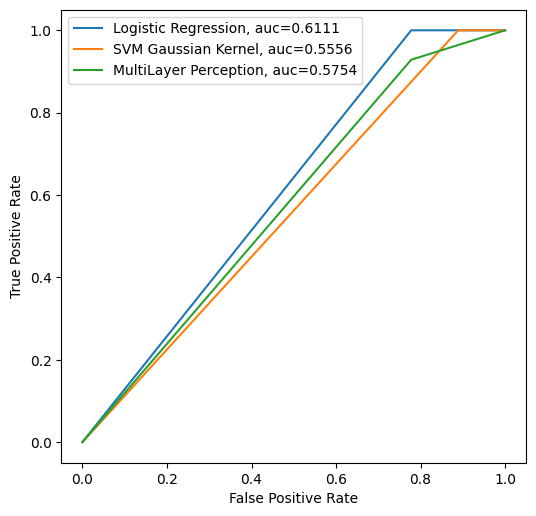

['logmirlet7', 'logmir145']
['BCC']

Training on:  126
Testing on:  23
Logistic Regression
--------------------
[[ 1  5]
 [ 1 16]]
Accuracy:  73.91304347826086 %
              precision    recall  f1-score   support

           0       0.50      0.17      0.25         6
           1       0.76      0.94      0.84        17

    accuracy                           0.74        23
   macro avg       0.63      0.55      0.55        23
weighted avg       0.69      0.74      0.69        23

--------------------
SVM
--------------------
[[ 1  5]
 [ 0 17]]
Accuracy:  78.26086956521739 %
              precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.77      1.00      0.87        17

    accuracy                           0.78        23
   macro avg       0.89      0.58      0.58        23
weighted avg       0.83      0.78      0.72        23

--------------------
MultiLayer Percepton
--------------------
[[ 2  4]
 [ 3 14]]
Accura

<Figure size 432x288 with 0 Axes>

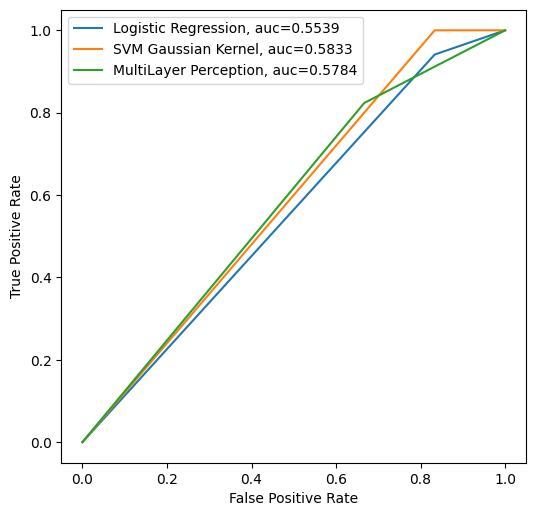

['logmirlet7', 'logmir145']
['Antaaldost']

Training on:  126
Testing on:  23
Logistic Regression
--------------------
[[ 2  5]
 [ 1 15]]
Accuracy:  73.91304347826086 %
              precision    recall  f1-score   support

           0       0.67      0.29      0.40         7
           1       0.75      0.94      0.83        16

    accuracy                           0.74        23
   macro avg       0.71      0.61      0.62        23
weighted avg       0.72      0.74      0.70        23

--------------------
SVM
--------------------
[[ 2  5]
 [ 0 16]]
Accuracy:  78.26086956521739 %
              precision    recall  f1-score   support

           0       1.00      0.29      0.44         7
           1       0.76      1.00      0.86        16

    accuracy                           0.78        23
   macro avg       0.88      0.64      0.65        23
weighted avg       0.83      0.78      0.74        23

--------------------
MultiLayer Percepton
--------------------
[[ 3  4]
 [ 2 14]]

<Figure size 432x288 with 0 Axes>

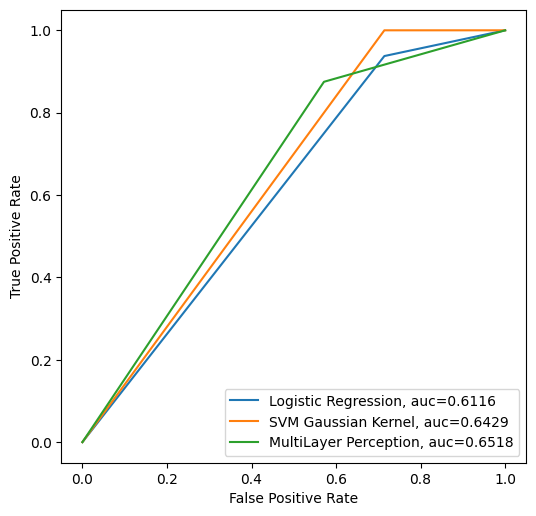

['logmirlet7', 'logmir145']
['agoalfacentral']

Training on:  125
Testing on:  23
Logistic Regression
--------------------
[[ 0  7]
 [ 0 16]]
Accuracy:  69.56521739130434 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.70      1.00      0.82        16

    accuracy                           0.70        23
   macro avg       0.35      0.50      0.41        23
weighted avg       0.48      0.70      0.57        23

--------------------
SVM
--------------------
[[ 1  6]
 [ 0 16]]
Accuracy:  73.91304347826086 %
              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.73      1.00      0.84        16

    accuracy                           0.74        23
   macro avg       0.86      0.57      0.55        23
weighted avg       0.81      0.74      0.66        23

--------------------
MultiLayer Percepton
--------------------
[[ 1  6]
 [ 0 

<Figure size 432x288 with 0 Axes>

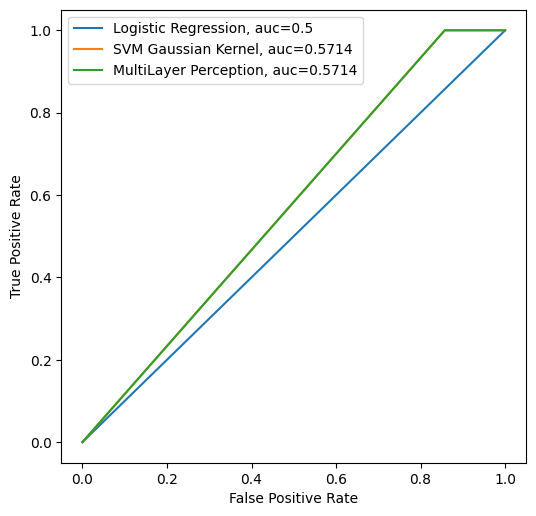

['logmirlet7', 'logmir145']
['agoalfaper']

Training on:  126
Testing on:  23
Logistic Regression
--------------------
[[ 0  6]
 [ 1 16]]
Accuracy:  69.56521739130434 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.73      0.94      0.82        17

    accuracy                           0.70        23
   macro avg       0.36      0.47      0.41        23
weighted avg       0.54      0.70      0.61        23

--------------------
SVM
--------------------
[[ 0  6]
 [ 0 17]]
Accuracy:  73.91304347826086 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.74      1.00      0.85        17

    accuracy                           0.74        23
   macro avg       0.37      0.50      0.42        23
weighted avg       0.55      0.74      0.63        23

--------------------
MultiLayer Percepton
--------------------
[[ 0  6]
 [ 4 13]]

<Figure size 432x288 with 0 Axes>

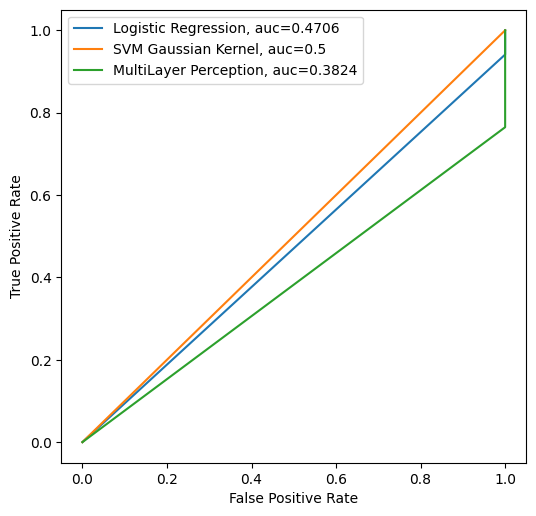

['logmirlet7', 'logmir145']
['vasodilat']

Training on:  125
Testing on:  23
Logistic Regression
--------------------
[[ 0 11]
 [ 0 12]]
Accuracy:  52.17391304347826 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.52      1.00      0.69        12

    accuracy                           0.52        23
   macro avg       0.26      0.50      0.34        23
weighted avg       0.27      0.52      0.36        23

--------------------
SVM
--------------------
[[ 1 10]
 [ 0 12]]
Accuracy:  56.52173913043478 %
              precision    recall  f1-score   support

           0       1.00      0.09      0.17        11
           1       0.55      1.00      0.71        12

    accuracy                           0.57        23
   macro avg       0.77      0.55      0.44        23
weighted avg       0.76      0.57      0.45        23

--------------------
MultiLayer Percepton
--------------------
[[ 4  7]
 [ 1 11]]


<Figure size 432x288 with 0 Axes>

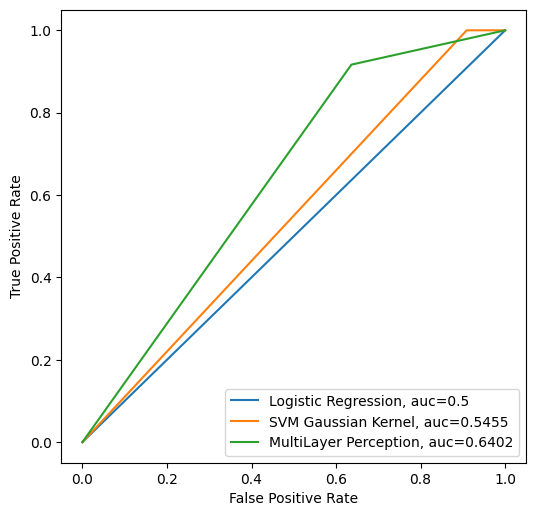

['logmirlet7', 'logmir145']
['statinas']

Training on:  126
Testing on:  23
Logistic Regression
--------------------
[[ 1  9]
 [ 0 13]]
Accuracy:  60.86956521739131 %
              precision    recall  f1-score   support

           0       1.00      0.10      0.18        10
           1       0.59      1.00      0.74        13

    accuracy                           0.61        23
   macro avg       0.80      0.55      0.46        23
weighted avg       0.77      0.61      0.50        23

--------------------
SVM
--------------------
[[ 1  9]
 [ 0 13]]
Accuracy:  60.86956521739131 %
              precision    recall  f1-score   support

           0       1.00      0.10      0.18        10
           1       0.59      1.00      0.74        13

    accuracy                           0.61        23
   macro avg       0.80      0.55      0.46        23
weighted avg       0.77      0.61      0.50        23

--------------------
MultiLayer Percepton
--------------------
[[ 2  8]
 [ 1 12]]
A

<Figure size 432x288 with 0 Axes>

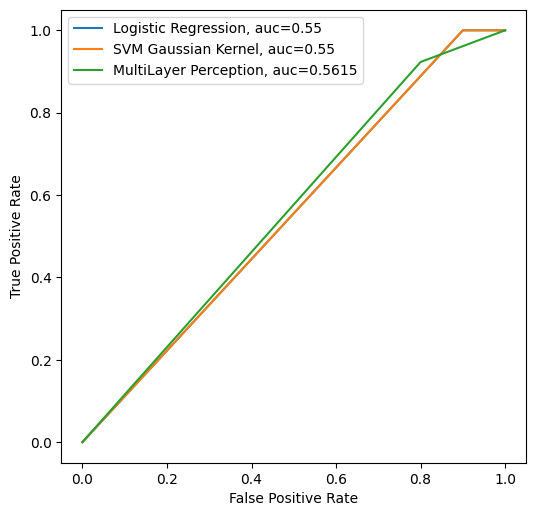

['logmirlet7', 'logmir145']
['AAS']

Training on:  126
Testing on:  23
Logistic Regression
--------------------
[[ 1  8]
 [ 0 14]]
Accuracy:  65.21739130434783 %
              precision    recall  f1-score   support

           0       1.00      0.11      0.20         9
           1       0.64      1.00      0.78        14

    accuracy                           0.65        23
   macro avg       0.82      0.56      0.49        23
weighted avg       0.78      0.65      0.55        23

--------------------
SVM
--------------------
[[ 1  8]
 [ 0 14]]
Accuracy:  65.21739130434783 %
              precision    recall  f1-score   support

           0       1.00      0.11      0.20         9
           1       0.64      1.00      0.78        14

    accuracy                           0.65        23
   macro avg       0.82      0.56      0.49        23
weighted avg       0.78      0.65      0.55        23

--------------------
MultiLayer Percepton
--------------------
[[ 1  8]
 [ 0 14]]
Accura

<Figure size 432x288 with 0 Axes>

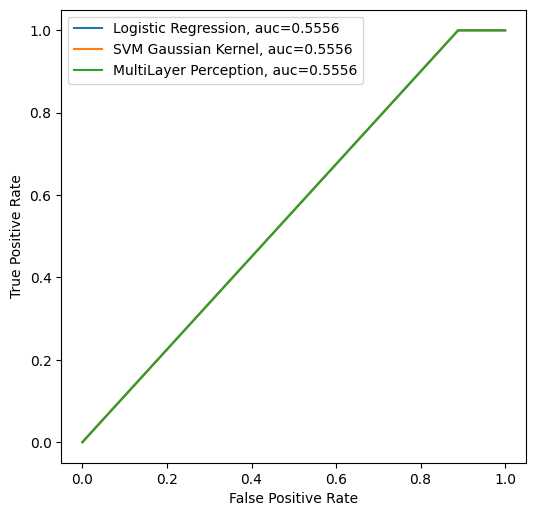

In [22]:
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

for mir in mirRNA:
  for v in v_set:
    df2 = df2.sample(frac = 1)

    if type(mir)==list:
      features = [*mir,*v]
    else:
      features = v.copy()
      features.append(mir)
    tfet = features.copy()
    tfet.append('StatusIMT')
    selected_columns = df2[tfet]
    selected_columns = selected_columns.dropna(axis=0)
    selected_columns = selected_columns.sample(frac = 1)
    selected_columns['StatusIMT'] = selected_columns['StatusIMT'].replace(2,0)
    X = selected_columns[features]
    y = selected_columns['StatusIMT']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123)

    print("="*50)
    print(mir)
    print(v)
    print("="*50)
    print()
    print("Training on: ",len(X_train))
    print("Testing on: ",len(X_test))

    
    #######log regression#####
    clf = LogisticRegression(penalty='l2', C=0.1)
    clf.fit(X_train, y_train)
    logpred = clf.predict(X_test)
    print('Logistic Regression')
    print('-'*20)
    print(confusion_matrix(y_test, logpred))
    print("Accuracy: ",metrics.accuracy_score(y_test, logpred)*100,"%")
    print(classification_report(y_test, logpred))
    print('-'*20)
    ###########svm#################
    print('SVM')
    print('-'*20)
    clf = svm.SVC(kernel='rbf')
    clf.fit(X_train, y_train)
    svmpred = clf.predict(X_test)
    print(confusion_matrix(y_test, svmpred))
    print("Accuracy: ",metrics.accuracy_score(y_test, svmpred)*100,"%")
    print(classification_report(y_test, svmpred))
    print('-'*20)
    ########mlp############
    print('MultiLayer Percepton')
    print('-'*20)
    mlppred = mlp(X_train, X_test, y_train, y_test,features)
    print(confusion_matrix(y_test,mlppred))
    print("Accuracy: ",metrics.accuracy_score(y_test, mlppred)*100,"%")
    print(classification_report(y_test, mlppred))
    print('-'*20)
    #print graph
    print_roc(y_test,logpred,svmpred,mlppred)
    #display(X)
    #display(y)